# Librerías

In [1]:
import os

# Librerias base para el analisis y manejo de datos
import numpy as np
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Librerias con los modelos principales
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids 

# Libnreria para medir los resultados de los modelos
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score

# Libreria para graficar
import matplotlib.pyplot as plt

# Estandarizar la data
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Seleccion de variables
from sklearn.feature_selection import mutual_info_regression

# Reducir la dimensionalidad para graficas
from sklearn.manifold import MDS

# metodo para recrear un iterador infinito
from itertools import cycle

from unidecode import unidecode

# Funciones

In [2]:
def convertir_col_numericas(df, lista_columnas):

    for columna in lista_columnas:

        df[columna] = df[columna].str.replace(',00', '', regex=False)
        df[columna] = df[columna].str.replace('.', '', regex=False)
        df[columna] = df[columna].str.replace(',', '.', regex=False).astype(float)

    return df

def porcentaje_participacion(df, lista_col, col_total):

    for col in lista_col:
        
        df[f'Porc_part_{col}'] = df[col] / df[col_total]

    return df


def crear_grafico_dispersion(modelo_fit, df, y):
    colors = plt.cm.tab20.colors + plt.cm.tab20b.colors
    color_cycle = cycle(colors)
    mds = MDS(n_components=2, dissimilarity = 'euclidean', random_state=123)
    df_transformado = mds.fit_transform(df)

    unique_labels = np.unique(modelo_fit.labels_)

    plt.figure(figsize=(10, 7))
    
    for idx, label in enumerate(unique_labels):
        color = next(color_cycle)  # Obtener el siguiente color del ciclo
        plt.scatter(df_transformado[modelo_fit.labels_ == label, 0], 
                    df_transformado[modelo_fit.labels_ == label, 1], 
                    label=f'Cluster {label}',
                    color=color)
    # Agregar las etiquetas de cada punto
    for i in range(df_transformado.shape[0]):
        plt.text(df_transformado[i, 0], 
                 df_transformado[i, 1], 
                 y.iloc[i, 0],  
                 fontsize=9, 
                 ha='right', 
                 color='black')

    plt.title('MDS Plot of Data with Labels')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

# Preparación bases de datos

## Base municipios

In [3]:
# Base Municipios
df_base = pd.read_excel("../Data/DIVIPOLA_Municipios.xlsx")

df_base['Departamento'] = df_base['Departamento'].apply(unidecode)
df_base['Municipio'] = df_base['Municipio'].apply(unidecode)
df_base['Municipio'] = df_base['Municipio'].replace('SAN ANDRES DE TUMACO', 'TUMACO')
df_base['Municipio'] = df_base['Municipio'].replace('SAN JOSE DE CUCUTA', 'CUCUTA')
df_base['Municipio'] = df_base['Municipio'].replace('CARTAGENA DE INDIAS', 'CARTAGENA')
df_base['Municipio'] = df_base['Municipio'].replace('VILLA DE SAN DIEGO DE UBATE', 'UBATE')
df_base['Municipio'] = df_base['Municipio'].replace('SANTIAGO DE CALI', 'CALI')
df_base['Municipio'] = df_base['Municipio'].replace('BOGOTA, D.C.', 'BOGOTA')
df_base['Departamento'] = df_base['Departamento'].replace('BOGOTA, D.C.', 'BOGOTA')

df_base['LLAVE'] = df_base['Departamento']+'_'+df_base['Municipio']

#
display(df_base.shape)
df_base.head(5)

(1122, 6)

,CodigoD,Departamento,CodigoM,Municipio,tipo,LLAVE
0,5,ANTIOQUIA,5001,MEDELLIN,Municipio,ANTIOQUIA_MEDELLIN
1,5,ANTIOQUIA,5002,ABEJORRAL,Municipio,ANTIOQUIA_ABEJORRAL
2,5,ANTIOQUIA,5004,ABRIAQUI,Municipio,ANTIOQUIA_ABRIAQUI
3,5,ANTIOQUIA,5021,ALEJANDRIA,Municipio,ANTIOQUIA_ALEJANDRIA
4,5,ANTIOQUIA,5030,AMAGA,Municipio,ANTIOQUIA_AMAGA


## Base Inclusion financiera y saldos por municipio

Se agregan ambas bases en un solo dataset debido a que manejan los mismos indices para identificar municipios y departamentos

### Base inlcusion financiera

In [4]:
# Base Municipios
df_inclusion = pd.read_csv("../Data/Inclusi_n_Financiera_20250515.csv")

#
display(df_inclusion.shape)
df_inclusion.head(5)

(367775, 99)

,TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,UNICAP,DESCRIP_UC,RENGLON,DESC_RENGLON,TIPO,(1) NRO_CORRESPONSALES_FÍSICOS_PROPIOS,(2) NRO_CORRESPONSALES_FÍSICOS_TERCERIZADOS,(3) NRO_CORRESPONSALES_FÍSICOS_ACTIVOS,(4) NRO_CORRESPONSALES_FÍSICOS,(5) NRO_DEPÓSITOS_CORRESPONSALES_FÍSICOS,(6) MONTO_DEPÓSITOS_CORRESPONSALES_FÍSICOS,(7) NRO_GIROS_ENVIADOS_CORRESPONSALES_FÍSICOS,(8) MONTO_GIROS_ENVIADOS_CORRESPONSALES_FÍSICOS,(9) NRO_GIROS_RECIBIDOS_CORRESPONSALES_FÍSICOS,(10) MONTO_GIROS_RECIBIDOS_CORRESPONSALES_FÍSICOS,(11) NRO_PAGOS_CORRESPONSALES_FÍSICOS,(12) MONTO_PAGOS_CORRESPONSALES_FÍSICOS,(13) NRO_RETIROS_CORRESPONSALES_FÍSICOS,(14) MONTO_RETIROS_CORRESPONSALES_FÍSICOS,(15) NRO_TRANSFERENCIAS_CORRESPONSALES_FÍSICOS,(16) MONTO_TRANSFERENCIAS_CORRESPONSALES_FÍSICOS,(17) NRO_TRANSACCIONES_TRÁMITES_CORRESPONSALES_FÍSICOS,(18) MONTO_TRANSACCIONES_CORRESPONSALES_FÍSICOS,(19) NRO_CTAS_AHORRO_HASTA_1SMMLV,(20) SALDO_CTAS_AHORRO_HASTA_1SMMLV,(21) NRO_CTAS_AHORRO>1SMMLV_HASTA _3SMMLV,(22) SALDO_CTAS_AHORRO>1SMMLV_HASTA _3SMMLV,(23) NRO_CTAS_AHORR>3SMMLV_HASTA_ 5SMMLV,(24) SALDO_CTAS_AHORR>3SMMLV_HASTA_ 5SMMLV,(25) NRO_CTAS_AHORRO_ACTIVAS,(26) SALDO_CTAS_AHORRO_ACTIVAS,(27) NRO_CTAS_AHORRO_MUJERES,(28) SALDO_CTAS_AHORRO_MUJERES,(29) NRO_CTAS_AHORRO_HOMBRES,(30) SALDO_CTAS_AHORRO_HOMBRES,(31) NRO_CTAS_AHORRO,(32) SALDO_CTAS_AHORRO,(41) NRO_CRÉDITO_CONSUMO_MUJERES,(42) MONTO_CRÉDITO_CONSUMO_MUJERES,(43) NRO_CRÉDITO_CONSUMO_HOMBRES,(44) MONTO_CRÉDITO_CONSUMO_HOMBRES,(45) NRO_CRÉDITO_CONSUMO,(46) MONTO_CRÉDITO_CONSUMO,(47) NRO_CRED_CONS_BAJO_MONTO_MUJERES,(48) MONTO_CRED_CONS_BAJO_MONTO_MUJERES,(49) NRO_CRED_CONS_BAJO_MONTO_HOMBRES,(50) MONTO_CRED_CONS_BAJO_MONTO_HOMBRES,(51) NRO_CRED_CONS_BAJO_MONTO,(52) MONTO_CRED_CONS_BAJO_MONTO,(53) NRO_CRÉDITO_VIVIENDA_MUJERES,(54) MONTO_CRÉDITO_VIVIENDA_MUJERES,(55) NRO_CRÉDITO_VIVIENDA_HOMBRES,(56) MONTO_CRÉDITO_VIVIENDA_HOMBRES,(57) NRO_CRÉDITO_VIVIENDA,(58) MONTO_CRÉDITO_VIVIENDA,(59) NRO_MICROCRÉDITO_HASTA_ 1SMMLV,(60) MONTO_MICROCRÉDITO_HASTA_1SMMLV,(61) NRO_MICROCRÉDITO_>1SMMLV_HASTA_ 2SMMLV,(62) MONTO_MICROCRÉDITO_>1SMMLV HASTA_ 2SMMLV,(63) NRO_MICROCRÉDITO_>2SMMLV_HASTA_3SMMLV,(64) MONTO_MICROCRÉDITO_> 2SMMLV_HASTA_3SMMLV,(65) NRO_MICROCRÉDITO_>3SMMLV_HASTA_ 4SMMLV,(66) MONTO_MICROCRÉDITO_>3SMMLV_HASTA_4SMMLV,(67) NRO_MICROCRÉDITO_>4SMMLV_HASTA_10SMMLV,(68) MONTO_MICROCRÉDITO_> 4SMMLV_HASTA_10SMMLV,(69) NRO_MICROCRÉDITO_>10SMMLV_HASTA_25SMMLV,(70) MONTO_MICROCRÉDITO_>10SMMLV_HASTA_ 25SMMLV,(71) NRO_MICROCRÉDITO_MUJERES,(72) MONTO_MICROCRÉDITO_MUJERES,(73) NRO_MICROCRÉDITO_HOMBRES,(74) MONTO_MICROCRÉDITO_HOMBRES,(75) NRO_MICROCRÉDITO,(76) MONTO_MICROCRÉDITO,(77) NRO_PRODUCTOS_A_NIVEL_NACIONAL,(78) MONTO_SALDO_PRODUCTOS_A_NIVEL_NACIONAL,(79) NRO_CORRESPONSALES_FÍSICOS_PROPIOS_ACTIVOS,(80) NRO_CORRESPONSALES_FÍSICOS_TERCERIZADOS_ACTIVOS,(81) NRO_CORRESPONSALES_PROPIOS_MÓVILES,(82) NRO_CORRESPONSALES_TERCERIZADOS_MÓVILES,(83) NRO_CORRESPONSALES_MÓVILES_ACTIVOS,(84) NRO_CORRESPONSALES_MÓVILES,(85) NRO_DEPÓSITOS_CORRESPONSALES_MÓVILES,(86) MONTO_DEPÓSITOS_CORRESPONSALES_MÓVILES,(87) NRO_GIROS_ENVIADOS_CORRESPONSALES_MÓVILES,(88) MONTO_GIROS_ENVIADOS_CORRESPONSALES_MÓVILES,(89) NRO_GIROS_RECIBIDOS_CORRESPONSALES_MÓVILES,(90) MONTO_GIROS_RECIBIDOS_CORRESPONSALES_MÓVILES,(91) NRO_PAGOS_CORRESPONSALES_MÓVILES,(92) MONTO_PAGOS_CORRESPONSALES_MÓVILES,(93) NRO_RETIROS_CORRESPONSALES_MÓVILES,(94) MONTO_RETIROS_CORRESPONSALES_MÓVILES,(95) NRO_TRANSFERENCIAS_CORRESPONSALES_MÓVILES,(96) MONTO_TRANSFERENCIAS_CORRESPONSALES_MÓVILES,(97) NRO_TRANSACCIONES_TRÁMITES_CORRESPONSALES_MÓVILES,(98) MONTO_TRANSACCIONES_CORRESPONSALES_MÓVILES
0,4,46,Coltefinanciera,31/03/2024,19,QUINDIO,999,TOTAL QUINDÍO,Corresponsales fisicos,1,9,10,10,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0.00,0,0,0,0.00
1,1,59,Banco 

In [5]:
df_inclusion['TIPO'].unique()

array(['Corresponsales fisicos', 'Cuentas de Ahorro',
       'Corresponsales físicos',
       'Transacciones y tramites a traves de corresponsales fisicos',
       'Microcredito por rango', 'Credito de consumo',
       'Transacciones corresponsal movil', 'Microcredito',
       'Productos a nivel nacional', 'Credito de consumo de bajo monto',
       'Credito de vivienda', 'Numero de corresponsales moviles'],
      dtype=object)

In [6]:
# Se eliminan registros no objeto de estudio
col_eliminar = ['Corresponsales fisicos', 'Corresponsales físicos', 'Productos a nivel nacional', 'Microcredito por rango']

In [7]:
df_inclusion1 = df_inclusion[~df_inclusion['TIPO'].isin(col_eliminar)]
df_inclusion1 = df_inclusion1.drop(columns=[col for col in df_inclusion1.columns if 'HOMBRES' in col or 'MUJERES' in col or 'DEPÓSITOS' in col
                                           or 'GIROS' in col or 'PAGOS' in col or 'RETIROS' in col or 'TRANSFERENCIAS' in col or 'SMMLV' in col
                                           or 'ACTIVAS' in col or 'ACTIVOS' in col or 'PROPIOS' in col or 'TERCERIZADOS' in col])

In [8]:
df_inclusion1['Total_Numero'] = df_inclusion1[[col for col in df_inclusion1.columns if 'NRO' in col]].sum(axis=1)
df_inclusion1['Total_Monto'] = df_inclusion1[[col for col in df_inclusion1.columns if 'MONTO' in col]].sum(axis=1)
df_inclusion1['Total_Saldo'] = df_inclusion1[[col for col in df_inclusion1.columns if 'SALDO' in col]].sum(axis=1)

In [9]:
df_inclusion1.head(10)

,TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,UNICAP,DESCRIP_UC,RENGLON,DESC_RENGLON,TIPO,(4) NRO_CORRESPONSALES_FÍSICOS,(17) NRO_TRANSACCIONES_TRÁMITES_CORRESPONSALES_FÍSICOS,(18) MONTO_TRANSACCIONES_CORRESPONSALES_FÍSICOS,(31) NRO_CTAS_AHORRO,(32) SALDO_CTAS_AHORRO,(45) NRO_CRÉDITO_CONSUMO,(46) MONTO_CRÉDITO_CONSUMO,(51) NRO_CRED_CONS_BAJO_MONTO,(52) MONTO_CRED_CONS_BAJO_MONTO,(57) NRO_CRÉDITO_VIVIENDA,(58) MONTO_CRÉDITO_VIVIENDA,(75) NRO_MICROCRÉDITO,(76) MONTO_MICROCRÉDITO,(77) NRO_PRODUCTOS_A_NIVEL_NACIONAL,(78) MONTO_SALDO_PRODUCTOS_A_NIVEL_NACIONAL,(84) NRO_CORRESPONSALES_MÓVILES,(97) NRO_TRANSACCIONES_TRÁMITES_CORRESPONSALES_MÓVILES,(98) MONTO_TRANSACCIONES_CORRESPONSALES_MÓVILES,Total_Numero,Total_Monto,Total_Saldo
2,1,30,Banco Caja Social S.A.,31/03/2024,11,CUNDINAMARCA,126,CAJICA,Cuentas de Ahorro,0,0,0.00,43198,41530976062.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,43198,0.00,41530976062.00
4,1,43,Banagrario,31/03/2024,2,ATLANTICO,560,PONEDERA,Transacciones y tramites a traves de correspon...,0,3142,1971644602.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,3142,1971644602.00,0.00
9,1,39,Banco Davivienda,31/03/2024,8,CAUCA,364,JAMBALO,Transacciones y tramites a traves de correspon...,0,57,13206705.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,57,13206705.00,0.00
12,1,57,Banco Pichincha S.A.,31/03/2024,6,CALDAS,999,TOTAL CALDAS,Credito de consumo,0,0,0.00,0,0.00,47,2017125453.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,47,2017125453.00,0.00
13,1,43,Banagrario,31/03/2024,11,CUNDINAMARCA,372,JUNIN,Cuentas de Ahorro,0,0,0.00,2976,6991234620.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,2976,0.00,6991234620.00
17,32,5,Confiar,31/03/2024,5,BOYACA,798,TENZA,Transacciones corresponsal movil,0,0,0.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,0,0.00,0.00
18,1,39,Banco Davivienda,31/03/2024,17,NARIÑO,215,CORDOBA,Transacciones y tramites a traves de correspon...,0,1052,172835717.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,1052,172835717.00,0.00
19,4,123,Bancar Tecnología C.F.,31/03/2024,24,VALLE DEL CAUCA,606,RESTREPO,Transacciones y tramites a traves de correspon...,0,2,350000.00,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,2,350000.00,0.00
24,4,117,Credifamilia,31/03/2024,3,BOGOTA,1,SANTAFE DE BOGOTA D.,Transacciones y tramites a traves de correspon...,0,15474,10831417760.32,0,0.00,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,15474,10831417760.32,0.00
25,1,42,Scotiabank Colpatria S.A.,31/03/2024,8,CAUCA,1,POPAYAN,Cuentas de Ahorro,0,0,0.00,15201,99831825360.22,0,0.00,0,0,0,0.00,0,0.00,0,0.00,0,0,0.00,15201,0.00,99831825360.22


### Saldos por municipio

In [10]:
df_saldos = pd.read_csv("../Data/Saldo_de_las_captaciones_y_colocaciones_por_municipios_20250515.csv")

#
display(df_saldos.shape)
df_saldos.head(5)

(25146, 80)

,Tipo de entidad,Código de entidad,Código del departamento,Código del municipio,Nombre del municipio,Fecha de Corte,Depósitos en cuenta corriente bancaria,Depósitos simples,Certificados de depósito a término,Depósitos de ahorro,Cuenta de ahorros de valor real,Cuentas de ahorro especial,Certificado de ahorro valor real,Documentos por pagar,Cuenta centralizada,Títulos de inversión en circulación,Cartera de créditos,Créditos de vivienda,Categoría A riesgo normal,Categoría B riesgo aceptable,Categoría C riesgo apreciable,Categoría D riesgo significativo,Categoría E riesgo de Incobrabilidad,"Categoría A riesgo normal, garantía idónea, créditos y leasing de consumo","Categoría B riesgo aceptable, garantía idónea, créditos y leasing de consumo","Categoría C riesgo apreciable, garantía idónea, créditos y leasing de consumo","Categoría D riesgo significativo, garantía idónea, créditos y leasing de consumo","Categoría E riesgo de incobrabilidad, garantía idónea, créditos y leasing de consumo","Categoría A riesgo normal, otras garantías, créditos y leasing de consumo","Categoría B riesgo aceptable, otras garantías, créditos y leasing de consumo","Categoría C riesgo apreciable, otras garantías, créditos y leasing de consumo","Categoría D riesgo significativo, otras garantías, créditos y leasing de consumo","Categoría E riesgo de incobrabilidad, otras garantías, créditos y leasing de consumo","Microcréditos, garantía idónea",Categoría A riesgo normal C29,Categoría B riesgo aceptable C30,Categoría C riesgo apreciable C31,Categoría D riesgo significativo C32,Categoría E riesgo de Incobrabilidad C33,Categoría A riesgo normal bienes dados en leasing C34,Categoría B riesgo aceptable bienes dados en leasing,Categoría C riesgo apreciable bienes dados en leasing,Categoría D riesgo significativo bienes dados en leasing,Categoría E riesgo de Incobrabilidad bienes dados en leasing,"Microcréditos, otras garantías",Categoría A riesgo normal C40,Categoría B riesgo aceptable C41,Categoría C riesgo apreciable C42,Categoría D riesgo significativo C43,Categoría E riesgo de Incobrabilidad C44,Categoría A riesgo normal bienes dados en leasing C45,Categoría B riesgo aceptable bienes dados en leasin C46,Categoría C riesgo apreciable bienes dados en leasing C47,Categoría D riesgo significativo bienes dados en leasing C48,Categoría E riesgo de Incobrabilidad bienes dados en leasing C49,"Categoría A riesgo normal, garantía idónea, créditos y leasing comerciales","Categoría B riesgo aceptable, garantía idónea, créditos y leasing comerciales","Categoría C riesgo apreciable, garantía idónea, créditos y leasing comerciales","Categoría D riesgo significativo, garantía idónea, créditos y leasing comerciales","Categoría E riesgo de incobrabilidad, garantía idónea, créditos y leasing comerciales","Categoría A riesgo normal, otras garantías, créditos y leasing comerciales","Categoría B riesgo aceptable, otras garantías, créditos y leasing comerciales","Categoría C riesgo apreciable, otras garantías, créditos y leasing comerciales","Categoría D riesgo significativo, otras garantías, créditos y leasing comerciales","Categoría E riesgo de incobrabilidad, otras garantías, créditos y leasing comerciales",Provisión créditos de vivienda,Provisión créditos y operaciones de leasing de consumo,Provisión microcréditos,Provisión créditos y operaciones de leasing comerciales,Provisión general,Número de CDT,Número de cuentas centralizadas,Número de oficinas,Número de empleados contratados,Número de empleados subcontratados,Componente contracíclico provisión individual,Derechos de transferencia de cartera de créditos por operaciones de apoyos transitorios de liquidez,Préstamos a empleados,Deterioro (provisión) préstamos a empleados,Crédito de consumo de bajo monto
0,1,54,2,999,TOTAL ATLANTICO,31/12/2024,13720536515.29,0.00,95730055626.39,50706442658.93,0,1387137819.89,0.00,0.00,0,0.00,369418264918.10,94732135062.00,87805425538.00,1621802675.00,1215884648.00,1736011736.00,2353010465.00,13

In [11]:
# Se eliminan variables no objeto de estudio
col_eliminar2 = ['Depósitos simples', 'Cuenta de ahorros de valor real', 'Certificado de ahorro valor real',
                 'Documentos por pagar', 'Cuenta centralizada', 'Títulos de inversión en circulación', 'Número de cuentas centralizadas',
                 'Número de oficinas', 'Número de empleados contratados', 'Número de empleados subcontratados', 'Componente contracíclico provisión individual',
                 'Derechos de transferencia de cartera de créditos por operaciones de apoyos transitorios de liquidez', 'Préstamos a empleados',
                 'Deterioro (provisión) préstamos a empleados', 'Número de CDT', 'Provisión créditos de vivienda', 'Provisión créditos y operaciones de leasing de consumo',
                 'Provisión microcréditos', 'Provisión créditos y operaciones de leasing comerciales']

In [12]:
df_saldos1 = df_saldos.drop(columns=col_eliminar2)

In [13]:
df_saldos1 = df_saldos1.drop(columns=[col for col in df_saldos1.columns if 'Categoría' in col])

In [14]:
df_saldos1.head(5)

,Tipo de entidad,Código de entidad,Código del departamento,Código del municipio,Nombre del municipio,Fecha de Corte,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,1,54,2,999,TOTAL ATLANTICO,31/12/2024,13720536515.29,95730055626.39,50706442658.93,1387137819.89,369418264918.10,94732135062.00,0.00,0,947321350.62,0.00
1,2,11,2,999,TOTAL ATLANTICO,31/12/2024,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00
2,1,65,33,999,TOTAL VICHADA,31/12/2024,0.00,0.00,20634423.40,0.00,105004921.06,0.00,0.00,0,0.00,0.00
3,4,46,2,999,TOTAL ATLANTICO,31/12/2024,0.00,50466877248.13,1917691630.96,0.00,8884066294.77,0.00,0.00,0,0.00,0.00
4,1,56,9,1,VALLEDUPAR,31/12/2024,5213997.00,10033136304.00,10324833854.00,0.00,26485769389.00,0.00,0.00,0,0.00,0.00


In [15]:
columnas_saldos = df_saldos1.columns[6:]

In [16]:
df_saldos2 = df_saldos1.groupby(['Código del departamento', 'Código del municipio'], as_index=False)[columnas_saldos].sum()

In [17]:
print(f"Cantidad de registros: {df_saldos2.shape[0]}")
df_saldos2.head(5)

Cantidad de registros: 1136


,Código del departamento,Código del municipio,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,1,1,21518165177687.11,256628043756287.44,129536376161561.78,827701702331.02,497346037428773.19,47272969911093.13,1680297796337.31,0,1536505567591.03,418479804964.22
1,1,2,5667716059.13,87967288907.05,89929330600.01,128179244.31,286420366741.25,37779672831.33,71445711052.04,0,968353097.59,0.00
2,1,4,0.00,0.00,3750520.48,0.00,93552322.25,0.00,87339818.88,0,0.00,0.00
3,1,21,12752973094.99,2581842338.00,6627800442.44,0.00,36445281479.87,197401624.00,30640797348.76,0,342945723.08,0.00
4,1,30,46651221669.25,110694770740.45,229420416256.72,690052690.12,379578586776.79,73739136701.63,36449474610.07,0,676195512.46,0.00


In [18]:
df_saldos2 = df_saldos2.rename(columns={
    'Código del departamento': 'UNICAP',
    'Código del municipio': 'RENGLON'
})

In [19]:
df_saldos2.head(1)

,UNICAP,RENGLON,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,1,1,21518165177687.11,256628043756287.44,129536376161561.78,827701702331.02,497346037428773.19,47272969911093.13,1680297796337.31,0,1536505567591.03,418479804964.22


### Union info financiera

In [20]:
# Paso 1: Crear dataframe base con valores únicos de DESCRIP_UC y DESC_RENGLON
df_inclusion2 = df_inclusion1[['DESCRIP_UC', 'DESC_RENGLON']].drop_duplicates().reset_index(drop=True)

# Paso 2: Iterar sobre cada valor único de TIPO
tipos_unicos = df_inclusion1['TIPO'].unique()

# Paso 3: Por cada TIPO, agrupar y renombrar columnas, luego hacer merge con df_base
for tipo in tipos_unicos:
    df_tmp = (
        df_inclusion1[df_inclusion1['TIPO'] == tipo]
        .groupby(['DESCRIP_UC','DESC_RENGLON'], as_index=False)[['Total_Numero', 'Total_Monto', 'Total_Saldo']]
        .sum()
    )
    
    # Paso 4: Renombrar columnas incluyendo el tipo
    df_tmp = df_tmp.rename(columns={
        'Total_Numero': f'Total_Numero_{tipo}',
        'Total_Monto': f'Total_Monto_{tipo}',
        'Total_Saldo': f'Total_Saldo_{tipo}'
    })
    
    # Paso 5: Merge al dataframe base
    df_inclusion2 = df_inclusion2.merge(df_tmp, on=['DESCRIP_UC', 'DESC_RENGLON'], how='left')



In [21]:
df_cod_inc = df_inclusion1[['UNICAP', 'DESCRIP_UC', 'RENGLON', 'DESC_RENGLON']].drop_duplicates().reset_index(drop=True)
df_cod_inc.shape

(1156, 4)

In [22]:
df_inc_cod = df_inclusion2.merge(df_cod_inc, on=['DESCRIP_UC', 'DESC_RENGLON'], how='left')

In [23]:
print(f"Cantidad de registros: {df_inc_cod.shape[0]}")
df_inc_cod.head(5)

Cantidad de registros: 1156


,DESCRIP_UC,DESC_RENGLON,Total_Numero_Cuentas de Ahorro,Total_Monto_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Saldo_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Saldo_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Saldo_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Saldo_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Saldo_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Saldo_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Monto_Numero de corresponsales moviles,Total_Saldo_Numero de corresponsales moviles,UNICAP,RENGLON
0,CUNDINAMARCA,CAJICA,658406.00,0.00,1411408475005.87,1458152,512970951855.55,0.00,227990.00,190360743120.59,0.00,150.00,31844847.00,0.00,967.00,14622740512.19,0.00,0.00,0.00,0.00,436.00,57566457312.58,0.00,15.00,0.00,0.00,11,126
1,ATLANTICO,PONEDERA,489.00,0.00,58924254.26,120755,43006240891.49,0.00,703.00,161350593.30,0.00,56.00,8821957.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00,2,560
2,CAUCA,JAMBALO,15396.00,0.00,44340305658.85,38996,17611943093.00,0.00,98.00,592142964.28,0.00,0.00,0.00,0.00,584.00,4724967826.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8,364
3,CALDAS,TOTAL CALDAS,6342548.00,0.00,10809986121402.48,16734970,6770021531407.32,0.00,1438335.00,1788709787080.19,0.00,118767.00,31196446163.00,0.00,27664.00,222631986137.58,0.00,0.00,0.00,0.00,2759.00,345598133641.79,0.00,167.00,0.00,0.00,6,999
4,CUNDINAMARCA,JUNIN,12286.00,0.00,26766501997.40,68189,16444505526.00,0.00,228.00,651392100.65,0.00,NaN,NaN,NaN,360.00,3959467051.31,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,11,372


In [24]:
# Se eliminan las siguientes columnas ya que dada la transformacion siempre van a ser NA o 0
col_no_validas = ['Total_Monto_Cuentas de Ahorro', 'Total_Saldo_Transacciones y tramites a traves de corresponsales fisicos',
                  'Total_Saldo_Credito de consumo', 'Total_Saldo_Transacciones corresponsal movil', 'Total_Saldo_Microcredito',
                  'Total_Saldo_Credito de consumo de bajo monto', 'Total_Saldo_Credito de vivienda', 'Total_Monto_Numero de corresponsales moviles',
                  'Total_Saldo_Numero de corresponsales moviles']

In [25]:
df_inclusion3 = df_inc_cod.drop(columns=col_no_validas)
df_inclusion3['DESCRIP_UC'] = df_inclusion3['DESCRIP_UC'].replace('NARIÑO', 'NARINO')
df_inclusion3['DESC_RENGLON'] = df_inclusion3['DESC_RENGLON'].replace('COVEÑAS', 'COVENAS')
df_inclusion3['DESC_RENGLON'] = df_inclusion3['DESC_RENGLON'].replace('(UBATE) VILLA DE SANDIEGO DE UBATE', 'UBATE')
df_inclusion3['DESC_RENGLON'] = df_inclusion3['DESC_RENGLON'].replace('DOS QUEBRADAS', 'DOSQUEBRADAS')
df_inclusion3['DESC_RENGLON'] = df_inclusion3['DESC_RENGLON'].replace('SANTAFE DE BOGOTA D.', 'BOGOTA')

df_inclusion3['LLAVE']=df_inclusion3['DESCRIP_UC']+'_'+df_inclusion3['DESC_RENGLON']

In [26]:
df_inclusion3['UNICAP'] = df_inclusion3['UNICAP'].astype(int)
df_inclusion3['RENGLON'] = df_inclusion3['RENGLON'].astype(int)

In [27]:
print(f"Cantidad de registros: {df_inclusion3.shape[0]}")
df_inclusion3.head(5)

Cantidad de registros: 1156


,DESCRIP_UC,DESC_RENGLON,Total_Numero_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,UNICAP,RENGLON,LLAVE
0,CUNDINAMARCA,CAJICA,658406.00,1411408475005.87,1458152,512970951855.55,227990.00,190360743120.59,150.00,31844847.00,967.00,14622740512.19,0.00,0.00,436.00,57566457312.58,15.00,11,126,CUNDINAMARCA_CAJICA
1,ATLANTICO,PONEDERA,489.00,58924254.26,120755,43006240891.49,703.00,161350593.30,56.00,8821957.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,2,560,ATLANTICO_PONEDERA
2,CAUCA,JAMBALO,15396.00,44340305658.85,38996,17611943093.00,98.00,592142964.28,0.00,0.00,584.00,4724967826.65,0.00,0.00,0.00,0.00,0.00,8,364,CAUCA_JAMBALO
3,CALDAS,TOTAL CALDAS,6342548.00,10809986121402.48,16734970,6770021531407.32,1438335.00,1788709787080.19,118767.00,31196446163.00,27664.00,222631986137.58,0.00,0.00,2759.00,345598133641.79,167.00,6,999,CALDAS_TOTAL CALDAS
4,CUNDINAMARCA,JUNIN,12286.00,26766501997.40,68189,16444505526.00,228.00,651392100.65,NaN,NaN,360.00,3959467051.31,0.00,0.00,NaN,NaN,NaN,11,372,CUNDINAMARCA_JUNIN


In [28]:
df_finan = df_inclusion3.merge(df_saldos2, on=['UNICAP', 'RENGLON'], how='left')

In [29]:
print(f"Cantidad de registros: {df_finan.shape[0]}")
df_finan.head(5)

Cantidad de registros: 1156


,DESCRIP_UC,DESC_RENGLON,Total_Numero_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,UNICAP,RENGLON,LLAVE,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,CUNDINAMARCA,CAJICA,658406.00,1411408475005.87,1458152,512970951855.55,227990.00,190360743120.59,150.00,31844847.00,967.00,14622740512.19,0.00,0.00,436.00,57566457312.58,15.00,11,126,CUNDINAMARCA_CAJICA,173607092983.11,656948151503.21,1445516991640.45,9681543532.76,2002020052080.15,832774109513.97,71515009161.94,0.00,2415495543.83,0.00
1,ATLANTICO,PONEDERA,489.00,58924254.26,120755,43006240891.49,703.00,161350593.30,56.00,8821957.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,2,560,ATLANTICO_PONEDERA,0.00,0.00,59771135.50,0.00,102925916.67,0.00,0.00,0.00,0.00,0.00
2,CAUCA,JAMBALO,15396.00,44340305658.85,38996,17611943093.00,98.00,592142964.28,0.00,0.00,584.00,4724967826.65,0.00,0.00,0.00,0.00,0.00,8,364,CAUCA_JAMBALO,4626024173.70,4242819967.91,44417727863.46,0.00,57332446944.86,0.00,49430651449.79,0.00,526840606.13,0.00
3,CALDAS,TOTAL CALDAS,6342548.00,10809986121402.48,16734970,6770021531407.32,1438335.00,1788709787080.19,118767.00,31196446163.00,27664.00,222631986137.58,0.00,0.00,2759.00,345598133641.79,167.00,6,999,CALDAS_TOTAL CALDAS,2875871969094.75,8530310551298.35,10728161952900.44,55349930668.28,34587795900707.58,7696126201585.84,1484678117093.79,0.00,51238820837.83,0.00
4,CUNDINAMARCA,JUNIN,12286.00,26766501997.40,68189,16444505526.00,228.00,651392100.65,NaN,NaN,360.00,3959467051.31,0.00,0.00,NaN,NaN,NaN,11,372,CUNDINAMARCA_JUNIN,8234237155.70,6364783950.29,26762539191.16,0.00,32815926478.78,0.00,28362546416.30,0.00,328347501.64,0.00


In [30]:
df_finan[df_finan['Depósitos en cuenta corriente bancaria'].isnull()].shape[1]

30

In [31]:
df_saldos = pd.read_csv("../Data/Saldo_de_las_captaciones_y_colocaciones_por_municipios_20250515.csv")

#
display(df_saldos.shape)
df_saldos.head(5)

(25146, 80)

,Tipo de entidad,Código de entidad,Código del departamento,Código del municipio,Nombre del municipio,Fecha de Corte,Depósitos en cuenta corriente bancaria,Depósitos simples,Certificados de depósito a término,Depósitos de ahorro,Cuenta de ahorros de valor real,Cuentas de ahorro especial,Certificado de ahorro valor real,Documentos por pagar,Cuenta centralizada,Títulos de inversión en circulación,Cartera de créditos,Créditos de vivienda,Categoría A riesgo normal,Categoría B riesgo aceptable,Categoría C riesgo apreciable,Categoría D riesgo significativo,Categoría E riesgo de Incobrabilidad,"Categoría A riesgo normal, garantía idónea, créditos y leasing de consumo","Categoría B riesgo aceptable, garantía idónea, créditos y leasing de consumo","Categoría C riesgo apreciable, garantía idónea, créditos y leasing de consumo","Categoría D riesgo significativo, garantía idónea, créditos y leasing de consumo","Categoría E riesgo de incobrabilidad, garantía idónea, créditos y leasing de consumo","Categoría A riesgo normal, otras garantías, créditos y leasing de consumo","Categoría B riesgo aceptable, otras garantías, créditos y leasing de consumo","Categoría C riesgo apreciable, otras garantías, créditos y leasing de consumo","Categoría D riesgo significativo, otras garantías, créditos y leasing de consumo","Categoría E riesgo de incobrabilidad, otras garantías, créditos y leasing de consumo","Microcréditos, garantía idónea",Categoría A riesgo normal C29,Categoría B riesgo aceptable C30,Categoría C riesgo apreciable C31,Categoría D riesgo significativo C32,Categoría E riesgo de Incobrabilidad C33,Categoría A riesgo normal bienes dados en leasing C34,Categoría B riesgo aceptable bienes dados en leasing,Categoría C riesgo apreciable bienes dados en leasing,Categoría D riesgo significativo bienes dados en leasing,Categoría E riesgo de Incobrabilidad bienes dados en leasing,"Microcréditos, otras garantías",Categoría A riesgo normal C40,Categoría B riesgo aceptable C41,Categoría C riesgo apreciable C42,Categoría D riesgo significativo C43,Categoría E riesgo de Incobrabilidad C44,Categoría A riesgo normal bienes dados en leasing C45,Categoría B riesgo aceptable bienes dados en leasin C46,Categoría C riesgo apreciable bienes dados en leasing C47,Categoría D riesgo significativo bienes dados en leasing C48,Categoría E riesgo de Incobrabilidad bienes dados en leasing C49,"Categoría A riesgo normal, garantía idónea, créditos y leasing comerciales","Categoría B riesgo aceptable, garantía idónea, créditos y leasing comerciales","Categoría C riesgo apreciable, garantía idónea, créditos y leasing comerciales","Categoría D riesgo significativo, garantía idónea, créditos y leasing comerciales","Categoría E riesgo de incobrabilidad, garantía idónea, créditos y leasing comerciales","Categoría A riesgo normal, otras garantías, créditos y leasing comerciales","Categoría B riesgo aceptable, otras garantías, créditos y leasing comerciales","Categoría C riesgo apreciable, otras garantías, créditos y leasing comerciales","Categoría D riesgo significativo, otras garantías, créditos y leasing comerciales","Categoría E riesgo de incobrabilidad, otras garantías, créditos y leasing comerciales",Provisión créditos de vivienda,Provisión créditos y operaciones de leasing de consumo,Provisión microcréditos,Provisión créditos y operaciones de leasing comerciales,Provisión general,Número de CDT,Número de cuentas centralizadas,Número de oficinas,Número de empleados contratados,Número de empleados subcontratados,Componente contracíclico provisión individual,Derechos de transferencia de cartera de créditos por operaciones de apoyos transitorios de liquidez,Préstamos a empleados,Deterioro (provisión) préstamos a empleados,Crédito de consumo de bajo monto
0,1,54,2,999,TOTAL ATLANTICO,31/12/2024,13720536515.29,0.00,95730055626.39,50706442658.93,0,1387137819.89,0.00,0.00,0,0.00,369418264918.10,94732135062.00,87805425538.00,1621802675.00,1215884648.00,1736011736.00,2353010465.00,13

In [32]:
# Se eliminan variables no objeto de estudio
col_eliminar2 = ['Depósitos simples', 'Cuenta de ahorros de valor real', 'Certificado de ahorro valor real',
                 'Documentos por pagar', 'Cuenta centralizada', 'Títulos de inversión en circulación', 'Número de cuentas centralizadas',
                 'Número de oficinas', 'Número de empleados contratados', 'Número de empleados subcontratados', 'Componente contracíclico provisión individual',
                 'Derechos de transferencia de cartera de créditos por operaciones de apoyos transitorios de liquidez', 'Préstamos a empleados',
                 'Deterioro (provisión) préstamos a empleados', 'Número de CDT', 'Provisión créditos de vivienda', 'Provisión créditos y operaciones de leasing de consumo',
                 'Provisión microcréditos', 'Provisión créditos y operaciones de leasing comerciales']

In [33]:
df_saldos1 = df_saldos.drop(columns=col_eliminar2)

In [34]:
df_saldos1 = df_saldos1.drop(columns=[col for col in df_saldos1.columns if 'Categoría' in col])

In [35]:
df_saldos1.head(10)

,Tipo de entidad,Código de entidad,Código del departamento,Código del municipio,Nombre del municipio,Fecha de Corte,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,1,54,2,999,TOTAL ATLANTICO,31/12/2024,13720536515.29,95730055626.39,50706442658.93,1387137819.89,369418264918.10,94732135062.00,0.00,0,947321350.62,0.00
1,2,11,2,999,TOTAL ATLANTICO,31/12/2024,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00
2,1,65,33,999,TOTAL VICHADA,31/12/2024,0.00,0.00,20634423.40,0.00,105004921.06,0.00,0.00,0,0.00,0.00
3,4,46,2,999,TOTAL ATLANTICO,31/12/2024,0.00,50466877248.13,1917691630.96,0.00,8884066294.77,0.00,0.00,0,0.00,0.00
4,1,56,9,1,VALLEDUPAR,31/12/2024,5213997.00,10033136304.00,10324833854.00,0.00,26485769389.00,0.00,0.00,0,0.00,0.00
5,1,65,5,491,NOBSA,31/12/2024,0.00,0.00,83674607.43,0.00,53580892.81,0.00,0.00,0,0.00,0.00
6,1,39,7,1,FLORENCIA,31/12/2024,13816805318.40,15605139719.09,133791485504.89,2229193.86,231318081213.47,45523952850.20,0.00,0,0.00,0.00
7,1,52,20,682,SANTA ROSA DE CABAL,31/12/2024,0.00,4124095938.63,1086551854.12,0.00,6092834208.72,0.00,5477250666.32,0,54772507.00,0.00
8,4,128,5,212,COPER,31/12/2024,0.00,0.00,2136730.60,0.00,4846045.18,0.00,0.00,0,0.00,0.00
9,1,1,23,1,IBAGUE,31/12/2024,86808506895.86,106880389631.00,181175906229.01,310417661.99,689651543279.56,169494336850.29,0.00,0,1694943368.42,0.00


## Mercado laboral

In [36]:
# Economia
df_mercadoLaboral = pd.read_csv("../Data/archivos_csv/Mercado_laboral.csv", sep=";", encoding="ISO-8859-1", low_memory=False)
df_mercadoLaboral = df_mercadoLaboral[df_mercadoLaboral['Año'] == 2016]
# 
display(df_mercadoLaboral.shape)
df_mercadoLaboral.head()

(25401, 13)

,Código Departamento,Departamento,Código Entidad,Entidad,Dimensión,Subcategoría,Indicador,Dato Numérico,Dato Cualitativo,Año,Mes,Fuente,Unidad de Medida
7945,99,Vichada,99624,Santa Rosalía,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"225,08",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7946,99,Vichada,99773,Cumaribo,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"8.743,92",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7947,99,Vichada,99524,La Primavera,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"410,33",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7948,99,Vichada,99001,Puerto Carreño,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"2.271,33",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores
7949,99,Vichada,99000,Vichada,Mercado laboral,Trabajadores cotizantes al sistema general de ...,Trabajadores cotizantes al sistema general de ...,"11.650,67",NaN,2016,12,FILCO- Ministerio del Trabajo,Trabajadores


In [37]:
df_mercadoLaboral['Subcategoría'].unique()

array(['Trabajadores cotizantes al sistema general de seguridad social (total anual)',
       'Trabajadores cotizantes al sistema general de seguridad social  según grupos de edad',
       'Composición de los trabajadores cotizantes al sistema general de seguridad social  según grupos de edad',
       'Trabajadores cotizantes al sistema general de seguridad social  según sexo',
       'Composición de los trabajadores cotizantes al sistema general de seguridad social  según sexo',
       'Número de empresas generadoras de empleo formal por cada 10.000 habitantes',
       'Ocupación formal'], dtype=object)

In [38]:
lista_laboral = ['Porcentaje de personas ocupadas formalmente con respecto a la población total']

In [39]:
df_mercadoLaboral1 = df_mercadoLaboral[df_mercadoLaboral['Indicador'].isin(lista_laboral)]

In [40]:
# dejar datos por municipio / son 23 años
df_mercadoLaboral1 = df_mercadoLaboral1.pivot(
    index=['Código Entidad', 'Entidad'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

In [41]:
df_mercadoLaboral1 = convertir_col_numericas(df_mercadoLaboral1, lista_laboral)

In [42]:
df_mercadoLaboral1 = df_mercadoLaboral1.rename(columns={
    'Porcentaje de personas ocupadas formalmente con respecto a la población total': 'Porc_trabajos_formales'
})

In [43]:
df_mercadoLaboral1['Porc_trabajos_formales'] = df_mercadoLaboral1['Porc_trabajos_formales'] / 100

In [44]:
df_mercadoLaboral1.head(5)

Indicador,Código Entidad,Entidad,Porc_trabajos_formales
0,1001,Colombia,0.28
1,5001,Medellín,0.62
2,5002,Abejorral,0.17
3,5004,Abriaquí,0.13
4,5021,Alejandría,0.14


## Transaccionalidad

In [45]:
df_transacciones = pd.read_csv("../Data/archivos_csv/transaccionalidad.csv", sep=",", encoding="utf-8")

In [46]:
display(df_transacciones.shape)
df_transacciones.head(3)

(5875015, 16)

,TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,FECHA_CORTE,UNIDAD_CAPTURA,NOMBRE_UNIDAD_CAPTURA,CODIGO_CANAL_DISTRIBUCION,CODIGO_SERRVICIO_TRANSACCIONAL,CODIGO_DEPARTAMENTO,CODIGO_MUNICIPIO,CODIGO_OPERACION,CODIGO_TIPO_PERSONA,CODIGO_CIIU,CODIGO_MECANISMO_CONFIRMACION,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,1,39,BANCO DAVIVIENDA,31/01/2023,2,Pagos por actividad económica,14,0,25,25175,0,0,17,0,2,1800000
1,1,52,BANCAMÍA S.A.,31/01/2023,2,Pagos por actividad económica,14,0,66,66170,0,0,869,0,1,549000
2,1,7,BANCOLOMBIA,31/01/2023,2,Pagos por actividad económica,9,0,13,13006,0,0,475,0,2,4230000


In [47]:
# Seleccionamos los codigos de operacion digitales
lista_operaciones_digitales = [1, 6, 7, 8, 13, 18]
df_transacciones = df_transacciones[df_transacciones['CODIGO_CANAL_DISTRIBUCION'].isin(lista_operaciones_digitales)]

In [48]:
df_transacciones1 = df_transacciones.groupby('CODIGO_MUNICIPIO', as_index=False)[['CANTIDAD_OPERACIONES', 'MONTO_OPERACIONES']].sum()


In [49]:
df_transacciones1.head(5)

,CODIGO_MUNICIPIO,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,0,17661129015,13449395752819554
1,5001,35020083,2969120450068
2,5002,3534,195297198
3,5004,37,9128754
4,5021,120,8469673


## Indice adopcion digital

### 2016

In [50]:
df_CNC_2016 = pd.read_csv("../Data/archivos_csv/d2016---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2016.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,PA,PB_MUN,PB_DANE,B1,PC,PD,KISH,PERS_NOMBRES_1,PERS_NOMBRES_2,PERS_NOMBRES_3,PERS_NOMBRES_4,PERS_NOMBRES_5,PERS_NOMBRES_6,PERS_NOMBRES_7,PERS_NOMBRES_8,PERS_SEXO_1,PERS_SEXO_2,PERS_SEXO_3,PERS_SEXO_4,PERS_SEXO_5,PERS_SEXO_6,PERS_SEXO_7,PERS_SEXO_8,PERS_EDAD_1,PERS_EDAD_2,PERS_EDAD_3,PERS_EDAD_4,PERS_EDAD_5,PERS_EDAD_6,PERS_EDAD_7,PERS_EDAD_8,DH,DIRECCION,RANGO_EDAD,FECHA_ACTUAL,HORA_INI,PH,SECTOR,SECCION,MANZANA,NOM_P1,SEXO_PER1,EDAD_PER1,NOM_P2,SEXO_PER2,EDAD_PER2,NOM_P3,SEXO_PER3,EDAD_PER3,NOM_P4,SEXO_PER4,EDAD_PER4,NOM_P5,SEXO_PER5,EDAD_PER5,NOM_P6,SEXO_PER6,EDAD_PER6,NOM_P7,SEXO_PER7,EDAD_PER7,NOM_P8,SEXO_PER8,EDAD_PER8,NOM_P9,SEXO_PER9,EDAD_PER9,NOM_P10,SEXO_PER10,EDAD_PER10,NOM_P11,SEXO_PER11,EDAD_PER11,NOM_P12,SEXO_PER12,EDAD_PER12,P2,P3,P4,NOMBRE_ENT,TEL_RES,CELULAR,DIRECCION_ENT,BARRIO,LON_1,LAT_1,ESTRATO,P6_1,P6_2,P6_3,P7,P8,P9,CONVIVENCIA,P10,P11_1,P11_2,P11_3,P11_4,P11_5,P11_6,P11_7,P11_8,P11_9,P11_10,P12,P13_1,P13_2,P13_3,P13_4,P13_5,P13_6,P13_7,P13_8,P13_9,P13_10,P13A_1,P13A_2,P13B_1,P13B_2,P13C,P13C_1_NUM,P13C_2,P13C_1_L,P13C_2_L,CP15,P15,P16,P17,P18,P21,P21_OTRO,P22,P23,P23_OTRO,CP23A_1,P23A_1,P23A,P23B,P24,P25,P26,P27,P28,P29_1,P29_2,P29_3,P29_4,P29_5,P29_6,P29_7,P29_8,P29_9,P29_10,P29_11,P29_12,P29_13,P29_14,P29_15,P29_16,P29_17,P29_18,P29_19,P29_20,P29_21,P29_22,P29_23,P29_24,P29_25,P29_26,P29_27,P29_28,P29_29,P29_30,P29_31,P29_32,P29_33,P29A_1,P29A_2,P29A_3,P29A_4,P29A_5,P29A_6,P29A_7,P29A_8,P29A_9,P29A_10,P29A_11,P29A_12,P29A_13,P29A_14,P29A_15,P29A_16,P29A_17,P29A_18,P29A_19,P29A_20,P29A_21,P29A_22,P29A_23,P29A_24,P29A_25,P29A_26,P29A_27,P29A_28,P29A_29,P29A_30,P29A_31,P29A_32,P29A_33,P29B_1,P29B_2,P29B_3,P29B_4,P29B_5,P29B_6,P29B_7,P29B_8,P29B_9,P29B_10,P29B_11,P29B_12,P29B_13,P29B_14,P29B_15,P29B_16,P29B_17,P29B_18,P29B_19,P29B_20,P29B_21,P29B_22,P29B_23,P29B_24,P29B_25,P29B_26,P29B_27,P29B_28,P29B_29,P29B_30,P29B_31,P29B_32,P29B_33,CP30,P30_1,P30_2,P30_3,P30_4,P30_5,P30A,P30B,P30B_CUALES_1,P30B_CUALES_2,P30B_CUALES_3,P30C,P30D,P30D_1,P30D_2,P30D_3,P30D_4,P30D_5,CP30E,P30E,P30F,P30G,P31,P31_OTRO,P32,CP37,P37,P38,P39,P40,P41_1,P41_2,P41_3,P41_4,P42,P42_OTRO,P43,P44_1,P44_2,P44_3,P44_4,P44_5,P44_6,P44_7,P44_8,P44_9,P46_ANIOS,P46_MESES,P49,P49_OTRO,P50,P50_OTRA,P55_HORAS,P55_MIN,P56_HORAS,P56_MIN,ROTACION,P57,P57_1,P57_2,P58,P59,P60_1,P60_2,P60_3,P60_51,P60_6,P60_7,P60_8,P60_9,P60_10,P60_11,P60_12,P60_13,P60_14,P60_15,P60_49,P60_16,P60_17,P60_18,P60_19,P60_20,P60_21,P60_22,P60_23,P60_24,P60_25,P60_26,P60_27,P60_29,P60_30,P60_32,P60_33,P60_34,P60_35,P60_36,P60_37,P60_38,P60_39,P60_40,P60_42,P60_43,P60_44,P60_45,P60_46,P60_47,P60_48,P60_50,P61_1,P61_2,P61_3,P61_51,P61_6,P61_7,P61_8,P61_9,P61_10,P61_11,P61_12,P61_13,P61_14,P61_15,P61_49,P61_16,P61_17,P61_18,P61_19,P61_20,P61_21,P61_22,P61_23,P61_24,P61_25,P61_26,P61_27,P61_29,P61_30,P61_32,P61_33,P61_34,P61_35,P61_36,P61_37,P61_38,P61_39,P61_40,P61_42,P61_43,P61_44,P61_45,P61_46,P61_47,P61_48,P61_50,P62_1,P62_2,P62_3,P62_51,P62_6,P62_7,P62_8,P62_9,P62_10,P62_11,P62_12,P62_13,P62_14,P62_15,P62_49,P62_16,P62_17,P62_18,P62_19,P62_20,P62_21,P62_22,P62_23,P62_24,P62_25,P62_26,P62_27,P62_29,P62_30,P62_32,P62_33,P62_34,P62_35,P62_36,P62_37,P62_38,P62_39,P62_40,P62_42,P62_43,P62_44,P62_45,P62_46,P62_47,P62_48,P62_50,P62A_1,P62A_2,P62A_3,P62A_51,P62A_6,P62A_7,P62A_8,P62A_9,P62A_10,P62A_11,P62A_12,P62A_13,P62A_14,P62A_15,P62A_49,P62A_16,P62A_17,P62A_18,P62A_19,P62A_20,P62A_21,P62A_22,P62A_23,P62A_24,P62A_25,P62A_26,P62A_27,P62A_29,P62A_30,P62A_32,P62A_33,P62A_34,P62A_35,P62A_36,P62A_37,P62A_38,P62A_39,P62A_40,P62A_42,P62A_43,P62A_44,P62A_45,P62A_46,P62A_47,P62A_48,P62A_50,P63,P63_OTRO,P64,P65,P65A,P65B,P65C,P65D,P65D_OTRA,P65E_1,P65E_2,P65E_3,P65E_4,P65E_5,P65E_6,P65E_7,P65E_8,P65E_9,P65E_10,P65E_11,P65E_12,P65E_13,P65E_14,P65E_15,P65E_16,P65E_17,P65E_18,P65E_19,P65E_20,P65E_21,P65E_22,P65E_23,P65E_24,P65E_25,P65E_26,P65E_27,P65E_28,P65E_29,P65E_30,P65

In [51]:
col_2016 = ['PB_DANE', 'INDICADOR']
df_CNC_2016 = df_CNC_2016[col_2016]

In [52]:
df_CNC_2016['INDICADOR'] = df_CNC_2016['INDICADOR'].str.replace(',', '.', regex=False).astype(float)

In [53]:
df_CNC_2016.head(3)

,PB_DANE,INDICADOR
0,11001,0.00
1,11001,0.00
2,11001,0.46


In [54]:
df_CNC_2016_1 = df_CNC_2016.groupby('PB_DANE', as_index=False)[['INDICADOR']].mean()
df_CNC_2016_1['Año_datos'] = 2016

In [55]:
df_CNC_2016_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.14,2016
1,5031,0.01,2016
2,5045,0.08,2016


### 2018

In [56]:
df_CNC_2018 = pd.read_csv("../Data/archivos_csv/d2018---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2018.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,GPSVAL,GPSALT,GPSLONG,GPSLAT,GPSPRECISION,IDAPK,IDBROWSER,IDDEVICE,IDMODE,IDMODEL,IDVERSO,IDVERSION,IDUSUARIO,IDEND,DIREC_VIVI,DH,EDAD,RANGO_EDAD,PA,PB,PB1,N_ENCUESTA,LAT_1,LONG_1,PC,PD,KISH,FECHA_ACTUAL,HORA_INI,PH,SECTOR,SECCION,MANZANA,XPD_1,P1_NOMBRES_1,P1_NOMBRES_2,P1_NOMBRES_3,P1_NOMBRES_4,P1_NOMBRES_5,P1_NOMBRES_6,P1_NOMBRES_7,P1_NOMBRES_8,P1_NOMBRES_9,P1_NOMBRES_10,P1_NOMBRES_11,P1_NOMBRES_12,P1_SEXO_1,P1_SEXO_2,P1_SEXO_3,P1_SEXO_4,P1_SEXO_5,P1_SEXO_6,P1_SEXO_7,P1_SEXO_8,P1_SEXO_9,P1_SEXO_10,P1_SEXO_11,P1_SEXO_12,P1_EDAD_1,P1_EDAD_2,P1_EDAD_3,P1_EDAD_4,P1_EDAD_5,P1_EDAD_6,P1_EDAD_7,P1_EDAD_8,P1_EDAD_9,P1_EDAD_10,P1_EDAD_11,P1_EDAD_12,SEXO,P2,P3,P4,NOM_ENTRE,TEL_ENTRE,CEL_ENTRE,DIR_ENTRE,BAR_ENTRE,EST_ENTRE,P6_1,P6_2,P6_3,P7,P8,P9,CONVIVENCIA,P10,P11,P12,P13,P13_1,P13_2,P13_3,P13_4,P13_5,P13_6,P13_7,P13_8,P13_9,P13_10,P13_11,P13_12,P13_13,P13_14,P13_15,P13_16,P13_17,P13_18,P13_19,P13_20,P13_21,P13_22,P13_23,P13_24,P13_25,P13_26,P13_27,P13_28,P13_29,P13_30,P13_31,P13_32,P13_33,P13_34,P13_35,P13_36,P13_37,P13_38,P13_39,P13_40,P13_41,P13_42,P13_43,P13_44,P13_45,P13_46,P13_47,P13_48,P14,P14_1,P14_2,P14_3,P14_4,P14_5,P14_6,P14_7,P14_8,P14_9,P14_10,P14_11,P14_12,P14_13,P14_14,P14_15,P14_16,P14_17,P14_18,P14_19,P14_20,P14_21,P14_22,P14_23,P14_24,P14_25,P14_26,P14_27,P14_28,P14_29,P14_30,P14_31,P14_32,P14_33,P14_34,P14_35,P14_36,P14_37,P14_38,P14_39,P14_40,P14_41,P14_42,P14_43,P14_44,P14_45,P14_46,P14_47,P14_48,P15,P16_1,P16_2,P16_3,P16_4,P16_5,P16_6,P16_7,P16_8,P16_9,P16_10,P16_11,P17,GPSLONG_1,GPSLAT_1,P18,P18TXT,P19,P20,P21,P22,P22OTRO,P23,P24,P24OTRO,P25,P26,P26TXT,P27,P27OTRO,P27A,P27ATXT,P28,P29,P30,P31,P32,P33,P34,P35,P36_1,P36_2,P36_3,P36_4,P37,P37_OTRO,P38,P39_1,P39_2,P39_3,P39_4,P39_5,P39_6,P39_7,P39_8,P39_9,P39_10,P39_11,P39_12,P39_13,P40_A,P40_M,P41,P41_OTRO,P42_H,P42_M,P43_H,P43_M,P44,P45,P46,P47,P48,P49,P50,P51_1,P51_2,P51_3,P51_4,P51_5,P51_6,P51_7,P51_8,P51_9,P51_10,P51_11,P51_12,P51_13,P51_14,P51_15,P51_16,P51_17,P51_18,P51_19,P51_20,P51_21,P51_22,P51_23,P51_24,P51_25,P51_26,P51_27,P51_28,P51_29,P51_30,P51_31,P51_32,P51_33,P52,P52_1,P52_2,P52_3,P52_4,P52_5,P53,P53TXT,P54,P54C,P54_CUAL,P55,P55C,P55_CUAL,P56,P57,P58,P59,P59_OTRO,P60_1,P60_2,P60_3,P60_4,P60_5,P60_6,P60_7,P60_8,P60_9,P60_10,P60_11,P60_12,P60_13,P60_14,P60_15,P60_16,P60_17,P60_18,P60_19,P60_20,P60_21,P60_22,P60_23,P60_24,P60_25,P60_26,P60_27,P60_28,P60_29,P60_30,P60_31,P60_32,P60_33,P60_34,P60_35,P60_36,P60_37,P60_38,P60_39,P60_40,P60_41,P60_42,P60_43,P60_44,P61,P62,P63,P63_OTRA,P64,P65,P66,P67,P67_OTRO,P68_1,P68_2,P68_3,P68_4,P68_5,P68_6,P68_7,P68_8,P68_9,P68_10,P68_11,P68_12,P68_13,P68_14,P68_15,P68_16,P68_17,P68_18,P68_19,P68_20,P68_21,P68_22,P68_23,P68_24,P69,P70,P71,P72,P72_OTRO,P73,P74_A,P74_M,P75,P75_OTRA,P76,P77,P78_1,P78_2,P78_3,P78_4,P79_1,P79_2,P79_3,P80_1,P80_2,P80_3,P80_4,P80_5,P80_6,P81_1,P81_2,P81_3,P81_4,P81_5,P82_1,P82_2,P82_3,P82_4,P82_5,P82_6,P82_7,P82_8,P83_1,P83_2,P83_3,P83_4,P83_5,P83_6,P83_7,P84,P85,P85_OTRA,P86,P87_1,P87_2,P87_3,P87_4,P88,P88_OTRA,P89_1,P89_2,P89_3,P89_4,P89_5,P89_6,P89_7,P89_8,P89_9,P89_10,P89_11,P89_12,P89_13,P89_14,P89_15,P89_16,P89_17,P89_18,P89_19,P89_20,P89_21,P89_22,P89_23,P89_24,P89_25,P89_26,P90,P91,P92,P92_OTRA,P93,P93_OTRA,P94,P95,P96,P97,P98_1,P98_2,P99,P100,P101,P102,P103,P104_H,P104_M,P105,P106,P107,P108_H,P108_M,P109_1,P109_2,P109_3,P109_4,P109_5,P109_6,P109_7,P109_8,P109_9,P110_1,P110_2,P110_3,P110_4,P110_5,P110_6,P110_7,P110_8,P110_9,P110_10,P110_11,P110_12,P110_13,P110_14,P110_15,P111,P111_OTRO,P112_1,P112_2,P112_3,P112_4,P112_5,P112_6,P113_1,P113_2,P113_3,P113_4,P113_5,P113_6,P114_1,P114_2,P114_3,P114_4,P114_5,P114_6,P115_1,P115_2,P115_3,P115_4,P115_5,P115_6,P116,P116_OTRA,P117,P118,P118_OTRA,P119,P120,P120_OTRO,P121,P121_OTRO,P122_NUM_1,P122_NUM_2,P122_NUM_3,P122_NUM_4,P122_NUM_5,P122_NUM_6,P122_NUM_7,P122_NUM_8,P122_NUM_9,P122_LETRA_1,P122_LETRA_2,P122_LETRA_3,P122_LETRA_4

In [57]:
col_2018 = ['PB', 'INDICADOR']
df_CNC_2018 = df_CNC_2018[col_2018]

In [58]:
df_CNC_2018_1 = df_CNC_2018.groupby('PB', as_index=False)[['INDICADOR']].mean()
df_CNC_2018_1['Año_datos'] = 2018

In [59]:
df_CNC_2018_1 = df_CNC_2018_1.rename(columns={
    'PB': 'PB_DANE'
})

In [60]:
df_CNC_2016_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.14,2016
1,5031,0.01,2016
2,5045,0.08,2016


### 2023

In [61]:
df_CNC_2023 = pd.read_csv("../Data/archivos_csv/d2023---copia.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_CNC_2023.head(5)

,ID,ESTUDIO,ENTREVISTADOR,REGISTRO,FECHAINI,HORAINI,FECHAFIN,HORAFIN,DURACION,TELEFONO,EMAIL,ID_CONTACTO,ESTADO,IDIOMA,IDCOORD,GPSVAL,GPSALT,GPSLONG,GPSLAT,GPSPRECISION,IDGUID,IDGUIDCONTACTO,IDGUIDREC,IDAPK,IDBROWSER,IDDEVICE,IDIP,IDMODE,IDMODEL,IDSCREEN,IDSO,IDPPI,IDVERBROWSER,IDVERSO,IDVERSION,IDUSUARIO,TIPO_ENCUESTA,TIPO,AUX99_1,IDEND,N_ENCUESTA,VERSION,GPSE,LONG_1,LAT_1,VERIFICA,FOTO,REGIONAL,PB1,ID_MANZANA,ID_MANZ_AUX,AUX99,CODDANE,POINT_X,POINT_Y,BAN,SECTOR,SECCION,MANZANA,ST_CARTOG,CIU,CONTACTO,ESTRATO_BASE,MUNICIPIO_BASE,REGION_BASE,REGION,MUNICIPIO_DEC,MUNICIPIO,DANE,VEREDA,PDET,ALEATORIO_PDET,PERSONAS,GENERO,PERSONAS_GEN,PFECACT,NOMBRE_1,SEXO_1,EDAD_1,PDIA_1,PMES_1,PFEC_1,DIAS_1,DIAS_DIFF_1,NOMBRE_2,SEXO_2,EDAD_2,PDIA_2,PMES_2,PFEC_2,DIAS_2,DIAS_DIFF_2,NOMBRE_3,SEXO_3,EDAD_3,PDIA_3,PMES_3,PFEC_3,DIAS_3,DIAS_DIFF_3,NOMBRE_4,SEXO_4,EDAD_4,PDIA_4,PMES_4,PFEC_4,DIAS_4,DIAS_DIFF_4,NOMBRE_5,SEXO_5,EDAD_5,PDIA_5,PMES_5,PFEC_5,DIAS_5,DIAS_DIFF_5,NOMBRE_6,SEXO_6,EDAD_6,PDIA_6,PMES_6,PFEC_6,DIAS_6,DIAS_DIFF_6,NOMBRE_7,SEXO_7,EDAD_7,PDIA_7,PMES_7,PFEC_7,DIAS_7,DIAS_DIFF_7,NOMBRE_8,SEXO_8,EDAD_8,PDIA_8,PMES_8,PFEC_8,DIAS_8,DIAS_DIFF_8,NOMBRE_9,SEXO_9,EDAD_9,PDIA_9,PMES_9,PFEC_9,DIAS_9,DIAS_DIFF_9,NOMBRE_10,SEXO_10,EDAD_10,PDIA_10,PMES_10,PFEC_10,DIAS_10,DIAS_DIFF_10,NOMBRE_11,SEXO_11,EDAD_11,0,PMES_11,PFEC_11,DIAS_11,DIAS_DIFF_11,NOMBRE_12,SEXO_12,EDAD_12,PDIA_12,PMES_12,PFEC_12,DIAS_12,DIAS_DIFF_12,NOMBRE_13,SEXO_13,EDAD_13,PDIA_13,PMES_13,PFEC_13,DIAS_13,DIAS_DIFF_13,NOMBRE_14,SEXO_14,EDAD_14,PDIA_14,PMES_14,PFEC_14,DIAS_14,DIAS_DIFF_14,NOMBRE_15,SEXO_15,EDAD_15,PDIA_15,PMES_15,PFEC_15,DIAS_15,DIAS_DIFF_15,DIRECCION_FILTRO,PROX,PERSONA_SELECCIONADA,NOMBRE_SEL,GENERO_SEL,EDAD,CONTINUAR,REDAD,AUTORIZA_INI_MAYOR,CONTINUAR_1,AUTORIZA_INI_MENOR,NOM_ADULTO,RELACION_MENOR,PARTICIPA_MENOR,REEMPLAZO,P2E_REEMPLAZO,AUTORIZA_INI_MAYOR_1,CONTINUAR_1_1,AUTORIZA_INI_MENOR_1,NOM_ADULTO_1,RELACION_MENOR_1,PARTICIPA_MENOR_1,B3_NOMBRES_1,B3_NOMBRES_2,B3_NOMBRES_3,B3_NOMBRES_4,B3_NOMBRES_5,B3_NOMBRES_6,B3_NOMBRES_7,B3_NOMBRES_8,B3_NOMBRES_9,B3_NOMBRES_10,B3_NOMBRES_11,B3_NOMBRES_12,B3_NOMBRES_13,B3_NOMBRES_14,B3_NOMBRES_15,B3_EDAD_1,B3_EDAD_2,B3_EDAD_3,B3_EDAD_4,B3_EDAD_5,B3_EDAD_6,B3_EDAD_7,B3_EDAD_8,B3_EDAD_9,B3_EDAD_10,B3_EDAD_11,B3_EDAD_12,B3_EDAD_13,B3_EDAD_14,B3_EDAD_15,B3_SEXO_1,B3_SEXO_2,B3_SEXO_3,B3_SEXO_4,B3_SEXO_5,B3_SEXO_6,B3_SEXO_7,B3_SEXO_8,B3_SEXO_9,B3_SEXO_10,B3_SEXO_11,B3_SEXO_12,B3_SEXO_13,B3_SEXO_14,B3_SEXO_15,B3_2,NOM_ENTRE,TEL_ENTRE,CEL_ENTRE,DIR_ENTRE,BAR_ENTRE,ST_DEC,ESTRATO,ST_GR,EVAL,CONTINUAR_2,B4_1,B4_2,Unnamed: 276,B4_3,B4_3_OTRO,B4_4_1,B4_4_2,B4_4_3,B4_4_TOTAL,CONTINUAR_3,B4_5_1,B4_5_2,B4_5_3,B4_5_4,B4_5_5,B4_5_TOTAL,CONTINUAR_4,B4_6_1,B4_6_2,B4_6_3,B4_6_51,B4_6_6,B4_6_7,B4_6_8,B4_6_9,B4_6_10,B4_6_11,B4_6_12,B4_6_13,B4_6_14,B4_6_15,B4_6_49,B4_6_16,B4_6_17,B4_6_18,B4_6_19,B4_6_20,B4_6_21,B4_6_22,B4_6_23,B4_6_24,B4_6_25,B4_6_26,B4_6_27,B4_6_29,B4_6_30,B4_6_32,B4_6_33,B4_6_34,B4_6_35,B4_6_36,B4_6_37,B4_6_38,B4_6_39,B4_6_40,B4_6_41,B4_6_42,B4_6_43,B4_6_44,B4_6_45,B4_6_46,B4_6_47,B4_6_48,B4_6_50,B4_6_66,B4_6_52,B4_6_53,B4_6_54,B4_6_55,B4_6_56,B4_6_57,B4_6_58,B4_6_59,B4_6_60,B4_6_61,B4_6_62,B4_6_64,B4_7,B5_1,B5_2_1,B5_2_2,B5_2_3,B5_2_4,B5_2_5,B5_2_6,B5_2_7,B5_2_8,B5_2_9,B5_2_10,B5_2_11,B5_2_12,B5_3_1,B5_3_2,B5_3_3,B5_3_4,B5_3_5,B5_3_6,B5_3_7,B5_3_8,B5_3_9,B5_3_10,B5_3_11,B5_3_12,B5_4_COMP_1,B5_4_COMP_2,B5_4_COMP_3,B5_4_COMP_4,B5_4_COMP_5,B5_4_COMP_6,B5_4_COMP_7,B5_4_COMP_8,B5_4_COMP_9,B5_4_COMP_10,B5_4_COMP_11,B5_4_COMP_12,B5_4_EXC_1,B5_4_EXC_2,B5_4_EXC_3,B5_4_EXC_4,B5_4_EXC_5,B5_4_EXC_6,B5_4_EXC_7,B5_4_EXC_8,B5_4_EXC_9,B5_4_EXC_10,B5_4_EXC_11,B5_4_EXC_12,CB5_5,B5_5,B5_6,B5_7,B5_8,B5_9,B5_9_OTRO,B5_10,B5_11,B5_11_OTRA,B5_12,B6_1,B6_1_OTRO,B6_2,B6_3,B6_4,B64_OTRO,B7_1,B7_2,B7_3A,B7_3M,B7_4,B7_5H,B7_5M,B8_1_1,B8_1_2,B8_1_3,B8_1_4,B8_1_5,B8_1_6,B8_1_7,B8_1_8,B8_1_9,B8_2_1,B8_2_2,B8_2_3,B8_2_4,B8_2_5,B8_2_6,B8_2_7,B8_2_8,B8_2_9,B8_2_10,B8_2_11,B8_2_12,B8_2_13,B8_2_14,B8_2_15,B8_2_16,B8_2_17,B8_2_18,B8_2_19,B8_2_20,B8_2_21,B8_2_

In [62]:
col_2023 = ['DANE', 'indicador']
df_CNC_2023 = df_CNC_2023[col_2023]

In [63]:
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.strip()
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.replace('-', '0', regex=False)
df_CNC_2023['indicador'] = df_CNC_2023['indicador'].str.replace(',', '.', regex=False).astype(float)

In [64]:
df_CNC_2023_1 = df_CNC_2023.groupby('DANE', as_index=False)[['indicador']].mean()
df_CNC_2023_1['Año_datos'] = 2023

In [65]:
df_CNC_2023_1 = df_CNC_2023_1.rename(columns={
    'DANE': 'PB_DANE',
    'indicador': 'INDICADOR'
})

In [66]:
df_CNC_2023_1.head(3)

,PB_DANE,INDICADOR,Año_datos
0,5001,0.31,2023
1,5031,0.29,2023
2,5045,0.17,2023


### Validacion columnas

In [67]:
print(df_CNC_2016_1.columns, df_CNC_2016_1.shape[0])
print(df_CNC_2018_1.columns, df_CNC_2018_1.shape[0])
print(df_CNC_2023_1.columns, df_CNC_2023_1.shape[0])

Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 61
Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 46
Index(['PB_DANE', 'INDICADOR', 'Año_datos'], dtype='object') 55


### Union todos los datasets

In [68]:
cnc_concat = pd.concat([df_CNC_2016_1, df_CNC_2018_1, df_CNC_2023_1], ignore_index=True)

In [69]:
cnc_concat.shape[0]

162

### Seleccion valor mas actualizado por municipio

In [70]:
# Ordena por cod_municipio y año (de más reciente a más antiguo)
cnc_concat1 = cnc_concat.sort_values(by=['PB_DANE', 'Año_datos'], ascending=[True, False])

# Elimina duplicados, conservando solo el más reciente por cod_municipio
cnc_concat1 = cnc_concat1.drop_duplicates(subset='PB_DANE', keep='first')

In [71]:
display(cnc_concat1.shape)
cnc_concat1.head(3)

(82, 3)

,PB_DANE,INDICADOR,Año_datos
107,5001,0.31,2023
108,5031,0.29,2023
109,5045,0.17,2023


In [72]:
cnc_concat_def = cnc_concat1[['PB_DANE', 'INDICADOR']]

# Armado dataframe Final

## Agregar info depto

In [73]:
df1 = pd.merge(cnc_concat_def, df_base[['CodigoD','CodigoM', 'Municipio','Departamento','LLAVE']], left_on='PB_DANE', right_on='CodigoM', how='left')

In [74]:
df1 = df1.drop(['CodigoM'], axis=1)

In [75]:
display(df1.shape)
df1.head(3)

(82, 6)

,PB_DANE,INDICADOR,CodigoD,Municipio,Departamento,LLAVE
0,5001,0.31,5,MEDELLIN,ANTIOQUIA,ANTIOQUIA_MEDELLIN
1,5031,0.29,5,AMALFI,ANTIOQUIA,ANTIOQUIA_AMALFI
2,5045,0.17,5,APARTADO,ANTIOQUIA,ANTIOQUIA_APARTADO


## Info Mercado Laboral

In [76]:
df6 = pd.merge(df1, df_mercadoLaboral1[['Código Entidad','Porc_trabajos_formales']], left_on='PB_DANE', right_on='Código Entidad', how='left')

In [77]:
df6 = df6.drop(['Código Entidad'], axis=1)
#df6 = df6.fillna(0)

In [78]:
display(df6.shape)
df6.head(3)

(82, 7)

,PB_DANE,INDICADOR,CodigoD,Municipio,Departamento,LLAVE,Porc_trabajos_formales
0,5001,0.31,5,MEDELLIN,ANTIOQUIA,ANTIOQUIA_MEDELLIN,0.62
1,5031,0.29,5,AMALFI,ANTIOQUIA,ANTIOQUIA_AMALFI,0.12
2,5045,0.17,5,APARTADO,ANTIOQUIA,ANTIOQUIA_APARTADO,0.29


## Info Transaccionalidad

In [79]:
df7 = pd.merge(df6, df_transacciones1, left_on='PB_DANE', right_on='CODIGO_MUNICIPIO', how='left')

In [80]:
df7 = df7.drop(['CODIGO_MUNICIPIO'], axis=1)

In [81]:
display(df7.shape)
df7.head(3)

(82, 9)

,PB_DANE,INDICADOR,CodigoD,Municipio,Departamento,LLAVE,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES
0,5001,0.31,5,MEDELLIN,ANTIOQUIA,ANTIOQUIA_MEDELLIN,0.62,35020083,2969120450068
1,5031,0.29,5,AMALFI,ANTIOQUIA,ANTIOQUIA_AMALFI,0.12,1836,128857908
2,5045,0.17,5,APARTADO,ANTIOQUIA,ANTIOQUIA_APARTADO,0.29,5145,1324013986


## Info financiera

In [82]:
df8 = pd.merge(df7, df_finan, left_on='LLAVE', right_on='LLAVE', how='left')

In [83]:
display(df8.shape)
df8.head(3)

(82, 38)

,PB_DANE,INDICADOR,CodigoD,Municipio,Departamento,LLAVE,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES,DESCRIP_UC,DESC_RENGLON,Total_Numero_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,UNICAP,RENGLON,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
0,5001,0.31,5,MEDELLIN,ANTIOQUIA,ANTIOQUIA_MEDELLIN,0.62,35020083,2969120450068,ANTIOQUIA,MEDELLIN,25943055.00,129671242139741.66,72079011,27413681315996.00,7340898.00,14623377570065.94,33688.00,7009122029.00,29907.00,342432552857.99,288743.00,225005586131.00,24126.00,3833395587878.78,424.00,1,1,21518165177687.11,256628043756287.44,129536376161561.78,827701702331.02,497346037428773.19,47272969911093.13,1680297796337.31,0.00,1536505567591.03,418479804964.22
1,5031,0.29,5,AMALFI,ANTIOQUIA,ANTIOQUIA_AMALFI,0.12,1836,128857908,ANTIOQUIA,AMALFI,35986.00,60798059764.96,446850,243367748265.00,11528.00,9556225658.60,0.00,0.00,274.00,3031182200.00,0.00,0.00,30.00,4211532354.00,4.00,1,31,30697763679.92,49900031440.51,60841194925.44,122287054.12,146112606188.78,47740036055.22,36459531235.00,0.00,419219613.61,0.00
2,5045,0.17,5,APARTADO,ANTIOQUIA,ANTIOQUIA_APARTADO,0.29,5145,1324013986,ANTIOQUIA,APARTADO,1257644.00,1133602316218.53,3293454,1690522134159.52,103939.00,248789293580.21,27.00,3926524.00,2853.00,29134726425.21,0.00,0.00,462.00,31254863802.85,15.00,1,45,300272905199.44,280486764292.02,1125972970713.66,3885496311.95,4438864080180.07,670003470304.19,204649430470.09,0.00,10388052207.72,0.00


In [84]:
df9 = df8.drop(columns=['CodigoD', 'Municipio', 'Departamento', 'LLAVE', 'UNICAP','RENGLON', 'DESCRIP_UC', 'DESC_RENGLON'])

nulos = df9['Depósitos en cuenta corriente bancaria'].isnull().sum()

print(f'Dimensiones finales del dataset: {df9.shape}')
print(f'Cantidad de registros nulos: {nulos}')
df9[df9['Depósitos en cuenta corriente bancaria'].isnull()]

Dimensiones finales del dataset: (82, 30)
Cantidad de registros nulos: 0


,PB_DANE,INDICADOR,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES,Total_Numero_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto


In [85]:
df9 = df9.set_index('PB_DANE')
df9.head(5)

,INDICADOR,Porc_trabajos_formales,CANTIDAD_OPERACIONES,MONTO_OPERACIONES,Total_Numero_Cuentas de Ahorro,Total_Saldo_Cuentas de Ahorro,Total_Numero_Transacciones y tramites a traves de corresponsales fisicos,Total_Monto_Transacciones y tramites a traves de corresponsales fisicos,Total_Numero_Credito de consumo,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Total_Monto_Transacciones corresponsal movil,Total_Numero_Microcredito,Total_Monto_Microcredito,Total_Numero_Credito de consumo de bajo monto,Total_Monto_Credito de consumo de bajo monto,Total_Numero_Credito de vivienda,Total_Monto_Credito de vivienda,Total_Numero_Numero de corresponsales moviles,Depósitos en cuenta corriente bancaria,Certificados de depósito a término,Depósitos de ahorro,Cuentas de ahorro especial,Cartera de créditos,Créditos de vivienda,"Microcréditos, garantía idónea","Microcréditos, otras garantías",Provisión general,Crédito de consumo de bajo monto
PB_DANE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5001,0.31,0.62,35020083,2969120450068,25943055.00,129671242139741.66,72079011,27413681315996.00,7340898.00,14623377570065.94,33688.00,7009122029.00,29907.00,342432552857.99,288743.00,225005586131.00,24126.00,3833395587878.78,424.00,21518165177687.11,256628043756287.44,129536376161561.78,827701702331.02,497346037428773.19,47272969911093.13,1680297796337.31,0.00,1536505567591.03,418479804964.22
5031,0.29,0.12,1836,128857908,35986.00,60798059764.96,446850,243367748265.00,11528.00,9556225658.60,0.00,0.00,274.00,3031182200.00,0.00,0.00,30.00,4211532354.00,4.00,30697763679.92,49900031440.51,60841194925.44,122287054.12,146112606188.78,47740036055.22,36459531235.00,0.00,419219613.61,0.00
5045,0.17,0.29,5145,1324013986,1257644.00,1133602316218.53,3293454,1690522134159.52,103939.00,248789293580.21,27.00,3926524.00,2853.00,29134726425.21,0.00,0.00,462.00,31254863802.85,15.00,300272905199.44,280486764292.02,1125972970713.66,3885496311.95,4438864080180.07,670003470304.19,204649430470.09,0.00,10388052207.72,0.00
5147,0.22,0.11,665,45517947,144053.00,144877378126.73,1358494,650252705224.00,13105.00,22873702668.14,33.00,5879874.00,1351.00,10511834181.94,0.00,0.00,11.00,1536978821.00,9.00,98236908921.33,31908937430.54,143686829853.21,341081889.99,319843436256.50,34356860127.93,44402764835.94,0.00,459592921.57,0.00
5266,0.44,0.26,1535208,936636951771,1748964.00,4751826417377.74,4443206,2173654183583.00,1094451.00,1701603505519.54,17.00,815544.00,2022.00,24514106163.54,0.00,0.00,1197.00,191657919678.45,15.00,627139350322.09,8997915992786.85,4915189734859.17,81086375849.21,22351154163673.41,2868979482863.06,126109842647.88,0.00,17984485131.87,0.00


In [86]:
df9 = df9.drop(index=11001)
df9.shape

(81, 29)

# Seleccion de variables

In [87]:
# Seleccion Umbrales
umbral_pearson = 0.15
umbral_spearman = 0.2
umbral_mi = 0.02

In [88]:
# Definimos la variable objetivo

target_col = 'INDICADOR'

# Subconjunto de variables numéricas (excluyendo la variable objetivo)
X = df9.drop(columns=[target_col])
y = df9[target_col]

# ======================
# 1. Correlación de Pearson
# ======================
pearson_corr = df9.corr(method='pearson')[target_col].drop(target_col)

# Filtramos las que tienen |r| > 0.3
pearson_selected = pearson_corr[pearson_corr.abs() > umbral_pearson].index.tolist()

# ======================
# 2. Correlación de Spearman
# ======================

spearman_corr = df9.corr(method='spearman')[target_col].drop(target_col)
spearman_selected = spearman_corr[spearman_corr.abs() > umbral_spearman].index.tolist()

# ======================
# 3. Mutual Information (captura relaciones no lineales)
# ======================
# Mutual Information requiere que X sea solo numérico
X_numeric = X.select_dtypes(include=np.number)
imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns)

# mutual_info_regression devuelve una lista de scores
mi_scores = mutual_info_regression(X_numeric_imputed, y, random_state=0)

# Creamos una serie para facilitar el análisis
mi_series = pd.Series(mi_scores, index=X_numeric.columns)

# Fijamos un umbral arbitrario (por ejemplo > 0.05) para relevancia
mi_selected = mi_series[mi_series > umbral_mi].index.tolist()

# ======================
# Resultados
# ======================
print(f"Variables seleccionadas por Pearson (|r| > {umbral_pearson}):", pearson_selected)
print(f"Variables seleccionadas por Spearman (|r| > {umbral_spearman}):", spearman_selected)
print(f"Variables seleccionadas por Mutual Information (> {umbral_mi}):", mi_selected)

# Puedes tomar la intersección o la unión según lo que desees
vars_comunes = set(pearson_selected) & set(spearman_selected) & set(mi_selected)
print("\nVariables comunes entre los tres métodos:", vars_comunes)


Variables seleccionadas por Pearson (|r| > 0.15): ['Porc_trabajos_formales', 'Total_Numero_Cuentas de Ahorro', 'Total_Numero_Transacciones y tramites a traves de corresponsales fisicos', 'Total_Monto_Transacciones y tramites a traves de corresponsales fisicos', 'Total_Numero_Credito de consumo', 'Total_Monto_Credito de consumo', 'Total_Numero_Transacciones corresponsal movil', 'Total_Numero_Microcredito', 'Total_Monto_Microcredito', 'Total_Numero_Credito de vivienda', 'Total_Monto_Credito de vivienda', 'Total_Numero_Numero de corresponsales moviles', 'Depósitos en cuenta corriente bancaria', 'Cuentas de ahorro especial', 'Créditos de vivienda', 'Microcréditos, garantía idónea']
Variables seleccionadas por Spearman (|r| > 0.2): ['Porc_trabajos_formales', 'CANTIDAD_OPERACIONES', 'MONTO_OPERACIONES', 'Total_Numero_Cuentas de Ahorro', 'Total_Saldo_Cuentas de Ahorro', 'Total_Numero_Transacciones y tramites a traves de corresponsales fisicos', 'Total_Monto_Transacciones y tramites a traves d

In [89]:
print(f"Cantidad de variables correlacion de Pearson > {umbral_pearson}: {len(pearson_selected)}")
print(f"Cantidad de variables correlacion de Spearman > {umbral_spearman}: {len(spearman_selected)}")
print(f"Cantidad de variables mutual information > {umbral_mi}: {len(mi_selected)}")
print(f"Cantidad de variables comunes: {len(vars_comunes)}")

Cantidad de variables correlacion de Pearson > 0.15: 16
Cantidad de variables correlacion de Spearman > 0.2: 22
Cantidad de variables mutual information > 0.02: 17
Cantidad de variables comunes: 10


In [90]:
df_final = df9[['INDICADOR'] + list(vars_comunes)]
df_final = df_final.fillna(0)
df_final.head(5)

,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo
PB_DANE,,,,,,,,,,,
5001,0.31,21518165177687.11,827701702331.02,0.62,342432552857.99,3833395587878.78,14623377570065.94,33688.00,47272969911093.13,424.00,7340898.00
5031,0.29,30697763679.92,122287054.12,0.12,3031182200.00,4211532354.00,9556225658.60,0.00,47740036055.22,4.00,11528.00
5045,0.17,300272905199.44,3885496311.95,0.29,29134726425.21,31254863802.85,248789293580.21,27.00,670003470304.19,15.00,103939.00
5147,0.22,98236908921.33,341081889.99,0.11,10511834181.94,1536978821.00,22873702668.14,33.00,34356860127.93,9.00,13105.00
5266,0.44,627139350322.09,81086375849.21,0.26,24514106163.54,191657919678.45,1701603505519.54,17.00,2868979482863.06,15.00,1094451.00


In [91]:
df_final[df_final.isnull().any(axis=1)]


,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo
PB_DANE,,,,,,,,,,,


# Construccion Modelo No Supervisado

## Escalado de los datos

In [92]:
col_escalar = df_final.columns[1:]

# Inicializar el escalador
scaler = StandardScaler()

# Aplicar el escalado solo a las columnas seleccionadas
df_scaled_part = pd.DataFrame(
    scaler.fit_transform(df_final[col_escalar]),
    columns=col_escalar,
    index=df_final.index
)

# Unir las columnas no escaladas con las escaladas
df_scaled = pd.concat([df_final[[df_final.columns[0]]], df_scaled_part], axis=1)

# Mostrar resultado
df_scaled.head(5)

,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo
PB_DANE,,,,,,,,,,,
5001,0.31,6.38,8.04,2.86,3.80,6.92,6.51,0.71,5.86,3.47,4.97
5031,0.29,-0.36,-0.29,-0.42,-0.66,-0.31,-0.35,-0.33,-0.36,-0.48,-0.38
5045,0.17,-0.27,-0.25,0.70,-0.32,-0.26,-0.24,-0.33,-0.28,-0.38,-0.31
5147,0.22,-0.34,-0.29,-0.52,-0.57,-0.32,-0.34,-0.33,-0.36,-0.43,-0.38
5266,0.44,-0.17,0.53,0.49,-0.38,0.04,0.44,-0.33,0.01,-0.38,0.41


## Desarrollo modelo

### K-Means

In [93]:
df_X = df_scaled
df_y = df_scaled.reset_index()[['PB_DANE']]

In [94]:
kmeans_1 = KMeans(n_clusters = 5, random_state = 42, n_init=10).fit(df_X)

In [95]:
# Obtener las etiquetas de cluster generadas por KMeans
cluster_labels_1= kmeans_1.labels_

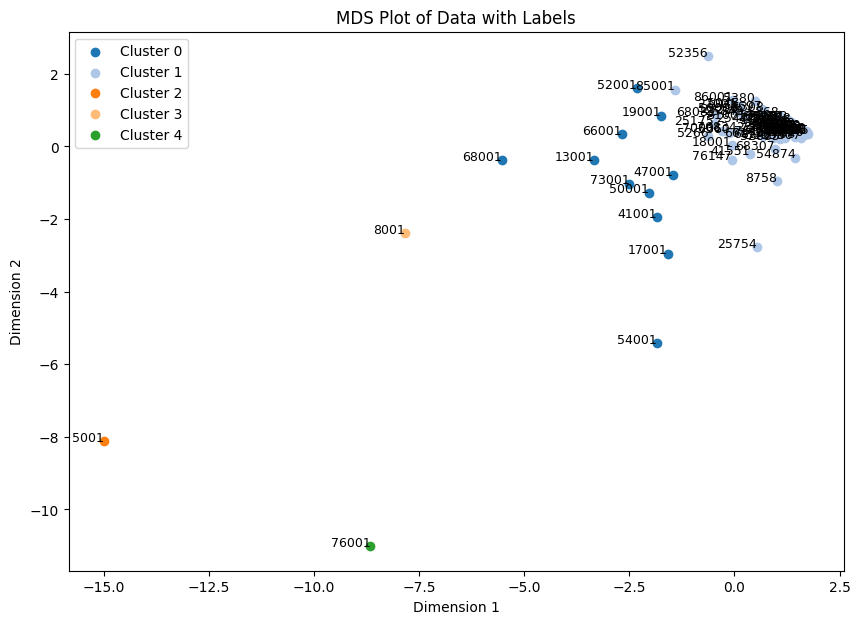

In [96]:
crear_grafico_dispersion(kmeans_1, df_X, df_y)

In [97]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, kmeans_1.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, kmeans_1.labels_))
print("Metrica de Inercia de k-means: ",kmeans_1.inertia_)

Metrica de silhouette_score:  0.617245923646565
Metrica de Calinski-Harabasz Index:  108.21366488378214
Metrica de Inercia de k-means:  121.13688005693935


### K-Medoides

In [98]:
Kmedoides_1 = KMedoids(n_clusters = 5, random_state = 42).fit(df_X)

In [99]:
cluster_labels_2= Kmedoides_1.labels_

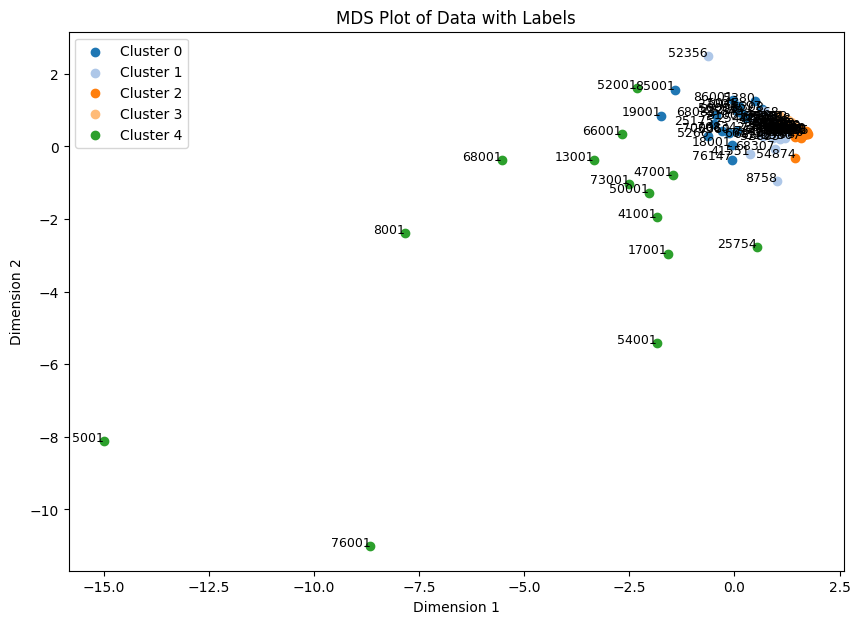

In [100]:
crear_grafico_dispersion(Kmedoides_1, df_X, df_y)

In [101]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, Kmedoides_1.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, Kmedoides_1.labels_))
print("Metrica de Inercia de k-means: ",Kmedoides_1.inertia_)

Metrica de silhouette_score:  0.1437109026416619
Metrica de Calinski-Harabasz Index:  16.812736856444683
Metrica de Inercia de k-means:  88.01277245917674


## Calibracion parámetros

### K-Means

In [102]:
# Numero de cluster a validar
rg=50

# Inicializar estructuras necesarias para la seleccion de cluster optimo
varianza_intra_cluster = []
silhouettes = []

# iterar entre todos los posibles clusters seleccionados para encontrar el optimo
for k in range (1, rg): # Evaluamos entre 1 a rg clusters posibles
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init=50).fit(df_X)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_X, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

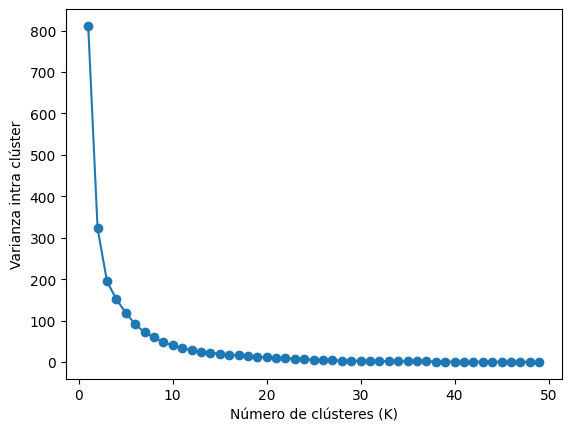

In [103]:
# Graficar la varianza intra cluster por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

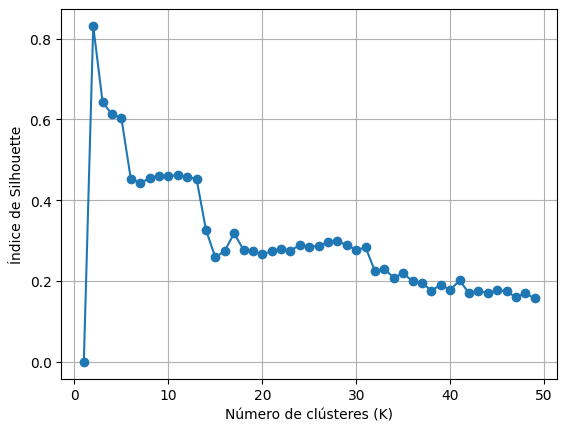

In [104]:
# Graficar el indice de sihoutette por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

### K-Medoides

In [105]:
# Numero de cluster a validar
rg=50

# Inicializar estructuras necesarias para la seleccion de cluster optimo
varianza_intra_cluster = []
silhouettes = []

# iterar entre todos los posibles clusters seleccionados para encontrar el optimo
for k in range (1, rg): # Evaluamos entre 1 a rg clusters posibles
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_X)
    varianza_intra_cluster.append(kmedoids.inertia_)
    try:
        silhouette = silhouette_score(df_X, kmedoids.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

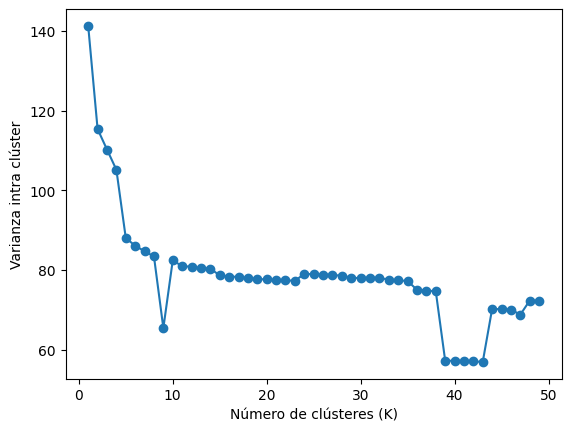

In [106]:
# Graficar la varianza intra cluster por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

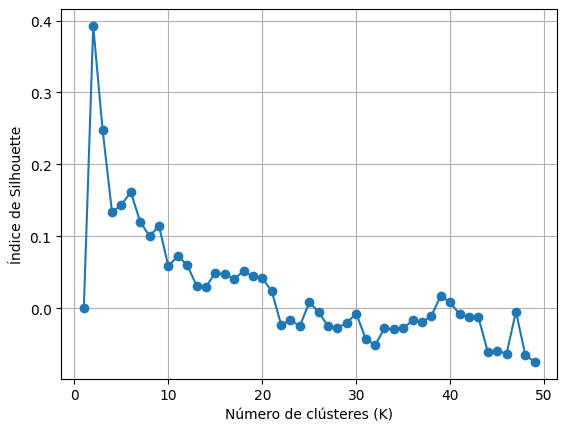

In [107]:
# Graficar el indice de sihoutette por cada uno de las posibles combinaciones de cluster a validar
plt.plot(range(1, rg), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

## Mejor modelo

In [108]:
kmeans_2 = KMeans(n_clusters = 12, random_state = 42, n_init=50).fit(df_X)

In [109]:
print("Metrica de silhouette_score: ",silhouette_score(df_X, kmeans_2.labels_))
print("Metrica de Calinski-Harabasz Index: ", calinski_harabasz_score(df_X, kmeans_2.labels_))
print("Metrica de Inercia de k-means: ",kmeans_2.inertia_)

Metrica de silhouette_score:  0.45790085831090377
Metrica de Calinski-Harabasz Index:  166.67710170542
Metrica de Inercia de k-means:  29.41662309444585


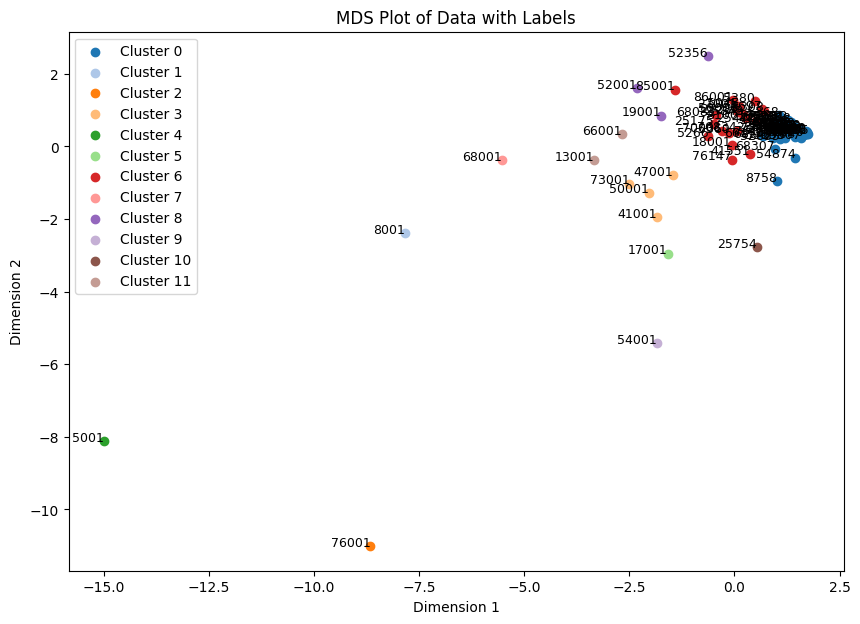

In [110]:
crear_grafico_dispersion(kmeans_2, df_X, df_y)

# Analisis Clusters - Mejor Modelo

## Analisis - clusters a data set original

In [111]:
# Obtener las etiquetas de cluster generadas por KMeans
X_clusters = df_final
X_clusters.insert(0, 'Cluster', kmeans_2.labels_)

# ver df con labels de clusters
X_clusters.head()

,Cluster,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo
PB_DANE,,,,,,,,,,,,
5001,4,0.31,21518165177687.11,827701702331.02,0.62,342432552857.99,3833395587878.78,14623377570065.94,33688.00,47272969911093.13,424.00,7340898.00
5031,0,0.29,30697763679.92,122287054.12,0.12,3031182200.00,4211532354.00,9556225658.60,0.00,47740036055.22,4.00,11528.00
5045,6,0.17,300272905199.44,3885496311.95,0.29,29134726425.21,31254863802.85,248789293580.21,27.00,670003470304.19,15.00,103939.00
5147,0,0.22,98236908921.33,341081889.99,0.11,10511834181.94,1536978821.00,22873702668.14,33.00,34356860127.93,9.00,13105.00
5266,6,0.44,627139350322.09,81086375849.21,0.26,24514106163.54,191657919678.45,1701603505519.54,17.00,2868979482863.06,15.00,1094451.00


In [112]:
col_dividir = ['Total_Monto_Credito de vivienda', 'Total_Monto_Credito de consumo', 'Depósitos en cuenta corriente bancaria', 'Créditos de vivienda', 'Cuentas de ahorro especial', 'Total_Monto_Microcredito']
millon = 1000000

for col in col_dividir:
    X_clusters[col] = X_clusters[col] / millon

In [113]:
X_clusters.head()

,Cluster,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo
PB_DANE,,,,,,,,,,,,
5001,4,0.31,21518165.18,827701.70,0.62,342432.55,3833395.59,14623377.57,33688.00,47272969.91,424.00,7340898.00
5031,0,0.29,30697.76,122.29,0.12,3031.18,4211.53,9556.23,0.00,47740.04,4.00,11528.00
5045,6,0.17,300272.91,3885.50,0.29,29134.73,31254.86,248789.29,27.00,670003.47,15.00,103939.00
5147,0,0.22,98236.91,341.08,0.11,10511.83,1536.98,22873.70,33.00,34356.86,9.00,13105.00
5266,6,0.44,627139.35,81086.38,0.26,24514.11,191657.92,1701603.51,17.00,2868979.48,15.00,1094451.00


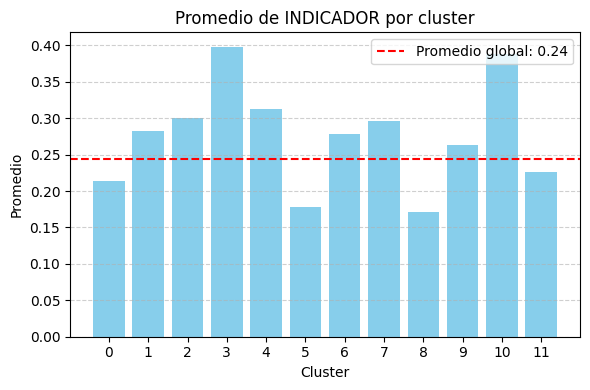

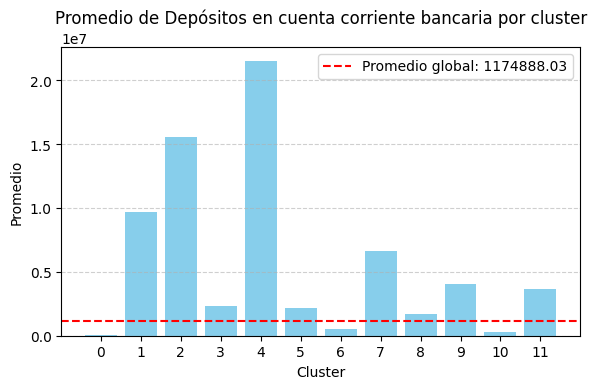

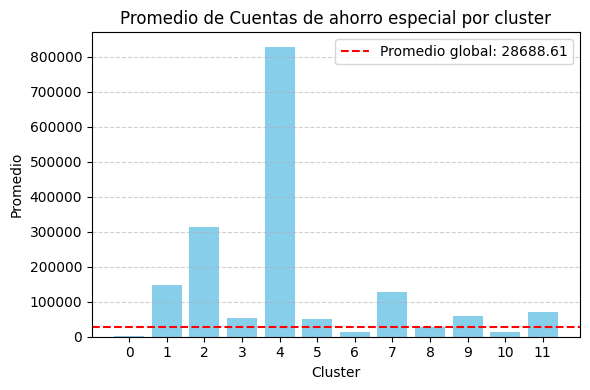

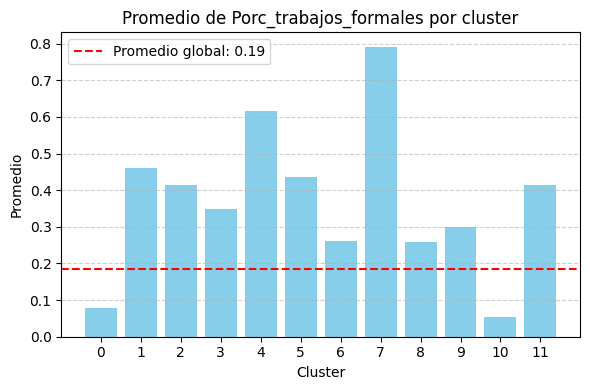

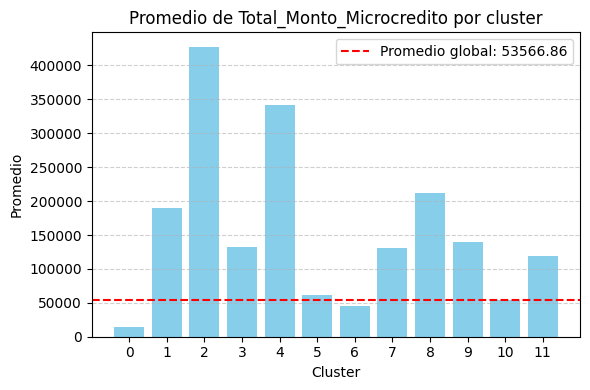

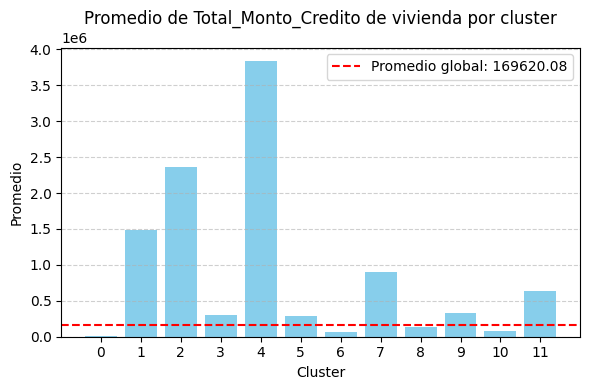

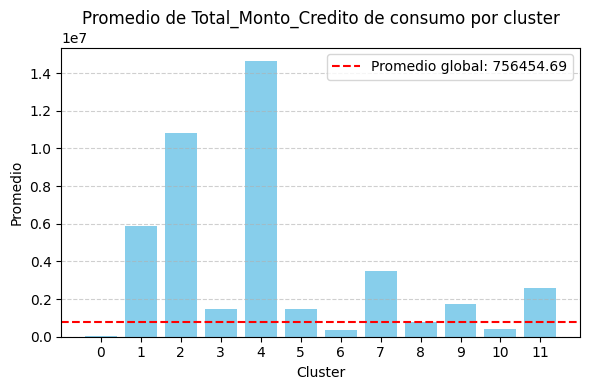

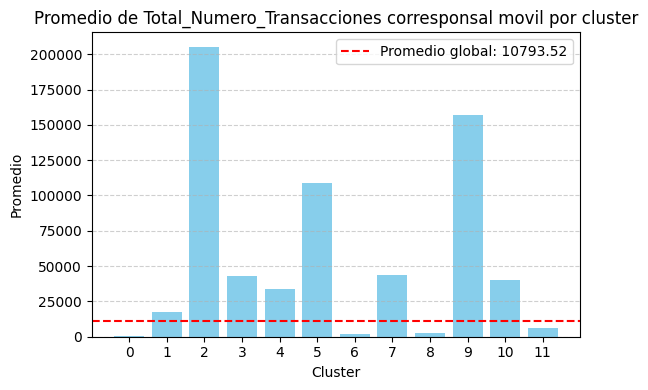

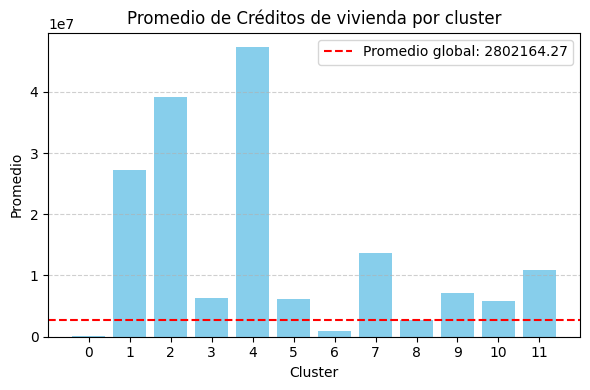

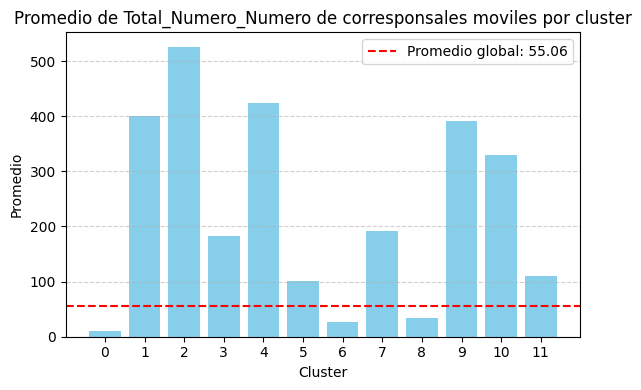

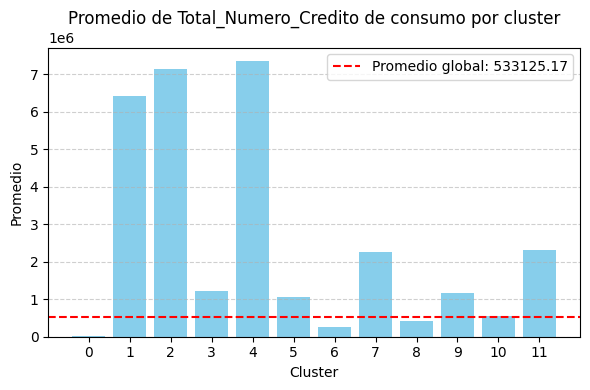

In [114]:
mean_by_cluster = X_clusters.groupby('Cluster').mean()

# Crear un gráfico por cada variable
for col in mean_by_cluster.columns:
    plt.figure(figsize=(6, 4))
    plt.bar(mean_by_cluster.index.astype(str), mean_by_cluster[col], color='skyblue')

    # Calcular y trazar línea del promedio global de la variable
    global_mean = X_clusters[col].mean()
    plt.axhline(global_mean, color='red', linestyle='--', label=f'Promedio global: {global_mean:.2f}')

    plt.title(f'Promedio de {col} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Promedio')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [115]:
X_clusters_reset = X_clusters.reset_index()

X_clusters_named = X_clusters_reset.merge(df_base[['CodigoM', 'Municipio']],
                                           left_on='PB_DANE',
                                           right_on='CodigoM',
                                           how='left')

municipios_por_cluster = X_clusters_named.groupby('Cluster')['Municipio'].apply(list).to_dict()

In [116]:
for cluster, municipios in municipios_por_cluster.items():
    print(f"Cluster {cluster}:", municipios )
    print()

Cluster 0: ['AMALFI', 'CAREPA', 'JERICO', 'SAN PEDRO DE URABA', 'YONDO', 'SOLEDAD', 'EL GUAMO', 'MIRAFLORES', 'GUAPI', 'AGUSTIN CODAZZI', 'BUENAVISTA', 'MONTELIBANO', 'PLANETA RICA', 'TIERRALTA', 'PACHO', 'RICAURTE', 'SAN FRANCISCO', 'ALGECIRAS', 'FUNDACION', 'GUAMAL', 'MESETAS', 'CUMBITARA', 'LA UNION', 'LEIVA', 'TUMACO', 'CONVENCION', 'EL CARMEN', 'SARDINATA', 'VILLA DEL ROSARIO', 'CIRCASIA', 'DOSQUEBRADAS', 'MARSELLA', 'CHARALA', 'GIRON', 'LEBRIJA', 'PIEDECUESTA', 'COVENAS', 'SAN MARCOS', 'ATACO', 'CHAPARRAL', 'RIOBLANCO', 'BUENAVENTURA', 'GINEBRA', 'MONTERREY']

Cluster 1: ['BARRANQUILLA']

Cluster 2: ['CALI']

Cluster 3: ['NEIVA', 'SANTA MARTA', 'VILLAVICENCIO', 'IBAGUE']

Cluster 4: ['MEDELLIN']

Cluster 5: ['MANIZALES']

Cluster 6: ['APARTADO', 'ENVIGADO', 'GIRARDOTA', 'ITAGUI', 'LA ESTRELLA', 'EL SANTUARIO', 'FLORENCIA', 'CHIA', 'FUNZA', 'MOSQUERA', 'UBATE', 'QUIBDO', 'PITALITO', 'ACACIAS', 'BARRANCABERMEJA', 'SINCELEJO', 'CARTAGO', 'TULUA', 'ARAUCA', 'YOPAL', 'MOCOA']

Cluster

# Conclusion - Clusters

## Conclusion calibracion de modelos

Se selecciona el modelo K-means con 12 clusters debido a que es el valor que maximiza la Metrica de Calinski-Harabasz Index in sacrificar mucho en el coeficiente de Silhouette. Este indicador mide la proporción entre la varianza entre clusters y la varianza dentro de los clusters, por lo que un valor mas alto indica clusters mejor separados y mas compactos.

Además de esto se obtiene el minimo para la Metrica de Inercia, donde se mide la distancia de cada punto a su centroide. Donde entre mas pequeño mejor.

## Exportar DataSet Final

In [ ]:
# Agregar educacion
df_educacion = pd.read_csv("../Data/archivos_csv/Educacion.csv", sep=";", encoding="ISO-8859-1", low_memory=False)

df_educacion = df_educacion[df_educacion['Año']==2022]

lista_educacion = ['Cobertura neta en educación - Total',
                   'Cobertura neta en educación media',
                   'Tasa de repitencia del sector oficial en educación básica y media (Desde transición hasta once)']
                   
df_educacion = df_educacion[df_educacion['Indicador'].isin(lista_educacion)]

df_educacion1 = df_educacion.pivot(
    index=['Código Entidad', 'Entidad'],
    columns='Indicador',
    values='Dato Numérico'
).reset_index()

df_educacion1 = df_educacion1.rename(columns={
    'Cobertura neta en educación - Total': 'Cobertura_edu_total',
    'Cobertura neta en educación media': 'Cobertura_edu_media',
    'Tasa de repitencia del sector oficial en educación básica y media (Desde transición hasta once)': 'Tasa_repitencia'
})

lista_edu1 = ['Cobertura_edu_total', 'Cobertura_edu_media', 'Tasa_repitencia']
df_educacion1 = convertir_col_numericas(df_educacion1, lista_edu1)

X_clusters_final = pd.merge(X_clusters_named, df_educacion1[['Código Entidad','Cobertura_edu_total','Cobertura_edu_media','Tasa_repitencia']], left_on='PB_DANE', right_on='Código Entidad', how='left')

In [128]:
X_clusters_final.head()

,PB_DANE,Cluster,INDICADOR,Depósitos en cuenta corriente bancaria,Cuentas de ahorro especial,Porc_trabajos_formales,Total_Monto_Microcredito,Total_Monto_Credito de vivienda,Total_Monto_Credito de consumo,Total_Numero_Transacciones corresponsal movil,Créditos de vivienda,Total_Numero_Numero de corresponsales moviles,Total_Numero_Credito de consumo,CodigoM,Municipio,Código Entidad,Cobertura_edu_total,Cobertura_edu_media,Tasa_repitencia
0,5001,4,0.31,21518165.18,827701.70,0.62,342432.55,3833395.59,14623377.57,33688.00,47272969.91,424.00,7340898.00,5001,MEDELLIN,5001,97.06,56.18,6.41
1,5031,0,0.29,30697.76,122.29,0.12,3031.18,4211.53,9556.23,0.00,47740.04,4.00,11528.00,5031,AMALFI,5031,71.63,28.92,7.48
2,5045,6,0.17,300272.91,3885.50,0.29,29134.73,31254.86,248789.29,27.00,670003.47,15.00,103939.00,5045,APARTADO,5045,94.91,57.86,5.56
3,5147,0,0.22,98236.91,341.08,0.11,10511.83,1536.98,22873.70,33.00,34356.86,9.00,13105.00,5147,CAREPA,5147,94.16,45.83,7.48
4,5266,6,0.44,627139.35,81086.38,0.26,24514.11,191657.92,1701603.51,17.00,2868979.48,15.00,1094451.00,5266,ENVIGADO,5266,100.44,65.36,6.49


In [131]:
X_clusters_final.to_csv('DataSetFinalProyectoGradoMIAD.csv', index=False)